<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, pathloss step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst.extract_2d.extract_2d_step import Extract2dStep
    from jwst.srctype.srctype_step import SourceTypeStep
    from jwst.wavecorr.wavecorr_step import WavecorrStep
    from jwst.flatfield.flat_field_step import FlatFieldStep
    from jwst.pathloss.pathloss_step import PathLossStep
    from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


In [4]:
# Make sure that the version used is the right one

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.7.2
Using NPTT version:  2.0.1


<a id="intro_ID"></a>
# Test Description

The NIRSpec team developed an implementation of the pathloss step and compared the output to the pipeline output for this step. We expected machine precision differences (about 10^-7) but due to rounding differences in interpolation methods we relaxed the difference threshold to 10^-6. 

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py. There is a corresponding script for Multi Object Spectroscopy (MOS) and for Integral Field Unit (IFU) data. Each mode has a script for point source (ps) and for uniform source (uni).


Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pathloss/description.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/pathloss


### Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information 


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and pathloss validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the pathloss step, use the command:

$ strun jwst.pathloss.PathLossStep jwtest_previous_step_output.fits


These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.pathloss import PathLossStep
 
$\gt$ PathLossStep.call(jwtest_previous_step_output.fits)


PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests. To run PTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing was only FS and MOS, since extract_2d is skipped for IFU. Data sets are:
- IFU_PRISM_CLEAR


[Top of Page](#title_ID)

In [5]:
testing_data = {
                
                'ifu_prism_clear':{
                                  'uncal_file_nrs1': 'ifu_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'ifu_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': None }
                                
               }



In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data

Testing files for detector:  nrs1


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz/ifu_prism_nrs1_uncal.fits


2022-10-06 02:29:51,339 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-10-06 02:29:51,363 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 02:29:51,364 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 02:29:51,365 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 02:29:51,366 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 02:29:51,367 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 02:29:51,368 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 02:29:51,370 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 02:29:51,371 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 02:29:51,372 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 02:29:51,373 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 02:29:51,374 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 02:29:51,375 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 02:29:51,376 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 02:29:51,377 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 02:29:51,378 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 02:29:51,379 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 02:29:51,382 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 02:29:51,612 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz/ifu_prism_nrs1_uncal.fits',).


2022-10-06 02:29:51,624 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-10-06 02:29:51,838 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'ifu_prism_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 02:29:51,850 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0140.fits'.


2022-10-06 02:29:51,852 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits'.


2022-10-06 02:29:51,854 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0018.fits'.


2022-10-06 02:29:51,855 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits'.


2022-10-06 02:29:51,857 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 02:29:51,857 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits'.


2022-10-06 02:29:51,860 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-06 02:29:51,860 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-06 02:29:51,861 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-10-06 02:29:51,861 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0020.fits'.


2022-10-06 02:29:51,863 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0087.fits'.


2022-10-06 02:29:51,864 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 02:29:51,865 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 02:29:51,865 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 02:29:52,341 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:29:52,343 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:29:52,530 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-06 02:29:52,531 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 02:29:52,534 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 02:29:52,674 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:29:52,676 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:29:52,698 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits


2022-10-06 02:29:53,398 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 02:29:53,543 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:29:53,545 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz', 'n_pix_grow_sat': 1}


2022-10-06 02:29:53,567 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0020.fits


2022-10-06 02:29:55,702 - stpipe.Detector1Pipeline.saturation - INFO - Detected 37655 saturated pixels


2022-10-06 02:29:55,748 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 02:29:55,764 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 02:29:55,912 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:29:55,914 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:29:55,915 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-06 02:29:55,918 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 02:29:56,047 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:29:56,049 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:29:56,073 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0087.fits


2022-10-06 02:29:57,644 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-06 02:29:57,795 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:29:57,796 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 02:29:57,976 - stpipe.Detector1Pipeline.refpix - INFO - NIR full frame data


2022-10-06 02:29:57,977 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are valid for this mode:


2022-10-06 02:29:57,978 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-10-06 02:29:57,978 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-10-06 02:29:57,978 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-10-06 02:29:57,979 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-10-06 02:29:57,979 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is not applicable and is ignored:


2022-10-06 02:29:57,979 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-10-06 02:30:01,679 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 02:30:01,855 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:30:01,856 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:30:01,883 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0018.fits


2022-10-06 02:30:03,102 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 02:30:03,259 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:30:03,261 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz', 'dark_output': None}


2022-10-06 02:30:03,286 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0140.fits


2022-10-06 02:30:05,650 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-06 02:30:05,652 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-06 02:30:06,141 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 02:30:06,299 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:30:06,301 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 02:30:06,311 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-06 02:30:06,324 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-10-06 02:30:06,396 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits


2022-10-06 02:30:07,287 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 02:30:07,375 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-10-06 02:30:10,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29709 pixels with at least one CR from five or more groups.


2022-10-06 02:30:10,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from four groups.


2022-10-06 02:30:10,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3 pixels with at least one CR from three groups.


2022-10-06 02:30:15,263 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.97522 sec


2022-10-06 02:30:15,267 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.956316


2022-10-06 02:30:15,273 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 02:30:15,416 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:30:15,418 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 02:30:15,453 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits


2022-10-06 02:30:15,454 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-10-06 02:30:15,560 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 02:30:15,561 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-06 02:30:59,979 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2022-10-06 02:30:59,980 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-10-06 02:31:00,214 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 02:31:00,370 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:31:00,372 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:31:00,443 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 02:31:00,443 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 02:31:00,448 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 02:31:00,547 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:31:00,548 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:31:00,616 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 02:31:00,616 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 02:31:00,621 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 02:31:00,621 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 02:31:00,622 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 02:31:00,622 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 02:31:00,632 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 02:31:00,730 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:31:00,731 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 02:31:00,931 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.03312480077147484 deg


2022-10-06 02:31:00,932 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3411945700645447 deg


2022-10-06 02:31:00,932 - stpipe.AssignWcsStep - INFO - theta_y correction: -0.005294283663966503 deg


2022-10-06 02:31:00,934 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 02:31:04,128 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0034.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0028.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': '/grp/crds/cache/references/jwst/jwst_nirspec_ifupost_0004.asdf', 'ifufore': '/grp/crds/cache/references/jwst/jwst_nirspec_ifufore_0003.asdf', 'ifuslicer': '/grp/crds/cache/references/jwst/jwst_n

2022-10-06 02:31:08,754 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  156.176998032 -45.687618307 156.178780407 -45.687618307 156.178780407 -45.686330486 156.176998032 -45.686330486


2022-10-06 02:31:08,758 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-06 02:31:08,772 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 02:31:08,772 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-10-06 02:31:08,785 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.


2022-10-06 02:31:09,045 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:31:09,046 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 02:31:09,067 - stpipe.MSAFlagOpenStep - INFO - Using reference file /grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json


2022-10-06 02:31:09,068 - stpipe.JwstStep - INFO - JwstStep instance created.


2022-10-06 02:31:09,260 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.03312480077147484 deg


2022-10-06 02:31:09,261 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3411945700645447 deg


2022-10-06 02:31:09,261 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: -0.005294283663966503 deg


2022-10-06 02:31:09,263 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0 deg


2022-10-06 02:31:09,276 - stpipe.MSAFlagOpenStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]


2022-10-06 02:31:09,426 - stpipe.MSAFlagOpenStep - INFO - There are 5 open slits in quadrant 1


2022-10-06 02:31:09,471 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2


2022-10-06 02:31:09,497 - stpipe.MSAFlagOpenStep - INFO - There are 9 open slits in quadrant 3


2022-10-06 02:31:09,569 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 4


2022-10-06 02:31:09,595 - stpipe.MSAFlagOpenStep - INFO - There are 0 open slits in quadrant 5


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2585.2572652943927.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2329.91715711254.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2731.341633999907.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2095.6529334650595.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2085.8983001463794.
  warnings.warn(f"Invalid interval: upper bound {upper} "


2022-10-06 02:31:23,414 - stpipe.MSAFlagOpenStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 02:31:23,416 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep done


2022-10-06 02:31:23,427 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.


2022-10-06 02:31:23,830 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:31:23,832 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-06 02:31:23,841 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NRS_IFU


2022-10-06 02:31:23,841 - stpipe.SourceTypeStep - INFO - Input SRCTYAPT = UNKNOWN


2022-10-06 02:31:23,842 - stpipe.SourceTypeStep - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2022-10-06 02:31:23,845 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done


2022-10-06 02:31:23,855 - stpipe.WavecorrStep - INFO - WavecorrStep instance created.


2022-10-06 02:31:24,028 - stpipe.WavecorrStep - INFO - Step WavecorrStep running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:31:24,030 - stpipe.WavecorrStep - INFO - Step WavecorrStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 02:31:24,038 - stpipe.WavecorrStep - INFO - Skipping wavecorr correction for EXP_TYPE NRS_IFU


2022-10-06 02:31:24,041 - stpipe.WavecorrStep - INFO - Step WavecorrStep done


2022-10-06 02:31:24,051 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2022-10-06 02:31:24,225 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:31:24,226 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-06 02:34:07,924 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 02:34:07,925 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


2022-10-06 02:34:07,936 - stpipe.PathLossStep - INFO - PathLossStep instance created.


2022-10-06 02:34:08,634 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs1_uncal.fits>,).


2022-10-06 02:34:08,636 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-06 02:34:08,661 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_nirspec_pathloss_0003.fits


2022-10-06 02:34:08,703 - stpipe.PathLossStep - INFO - Input exposure type is NRS_IFU


2022-10-06 02:35:11,987 - stpipe.PathLossStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 02:35:11,988 - stpipe.PathLossStep - INFO - Step PathLossStep done


Running test for IFU...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS1   Grating: PRISM   Filter: CLEAR   Lamp: NO_LAMP   EXP_TYPE: NRS_IFU
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0003.fits


got input slices
PLCOR_REF.shape (21, 21, 21)
 Looping through the slices... 
working with slice 0
SHAPES (40, 439) (39, 438)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V6
final left 780, right 819, top 999, bottom 561
NEW SHAPE OF SLICE: (39, 438) and corr_vals.shape: (39, 438)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_ifu_uni.py:168: RuntimeWarning: invalid value encountered in divide
  pathloss_divided = comp_sci/previous_sci


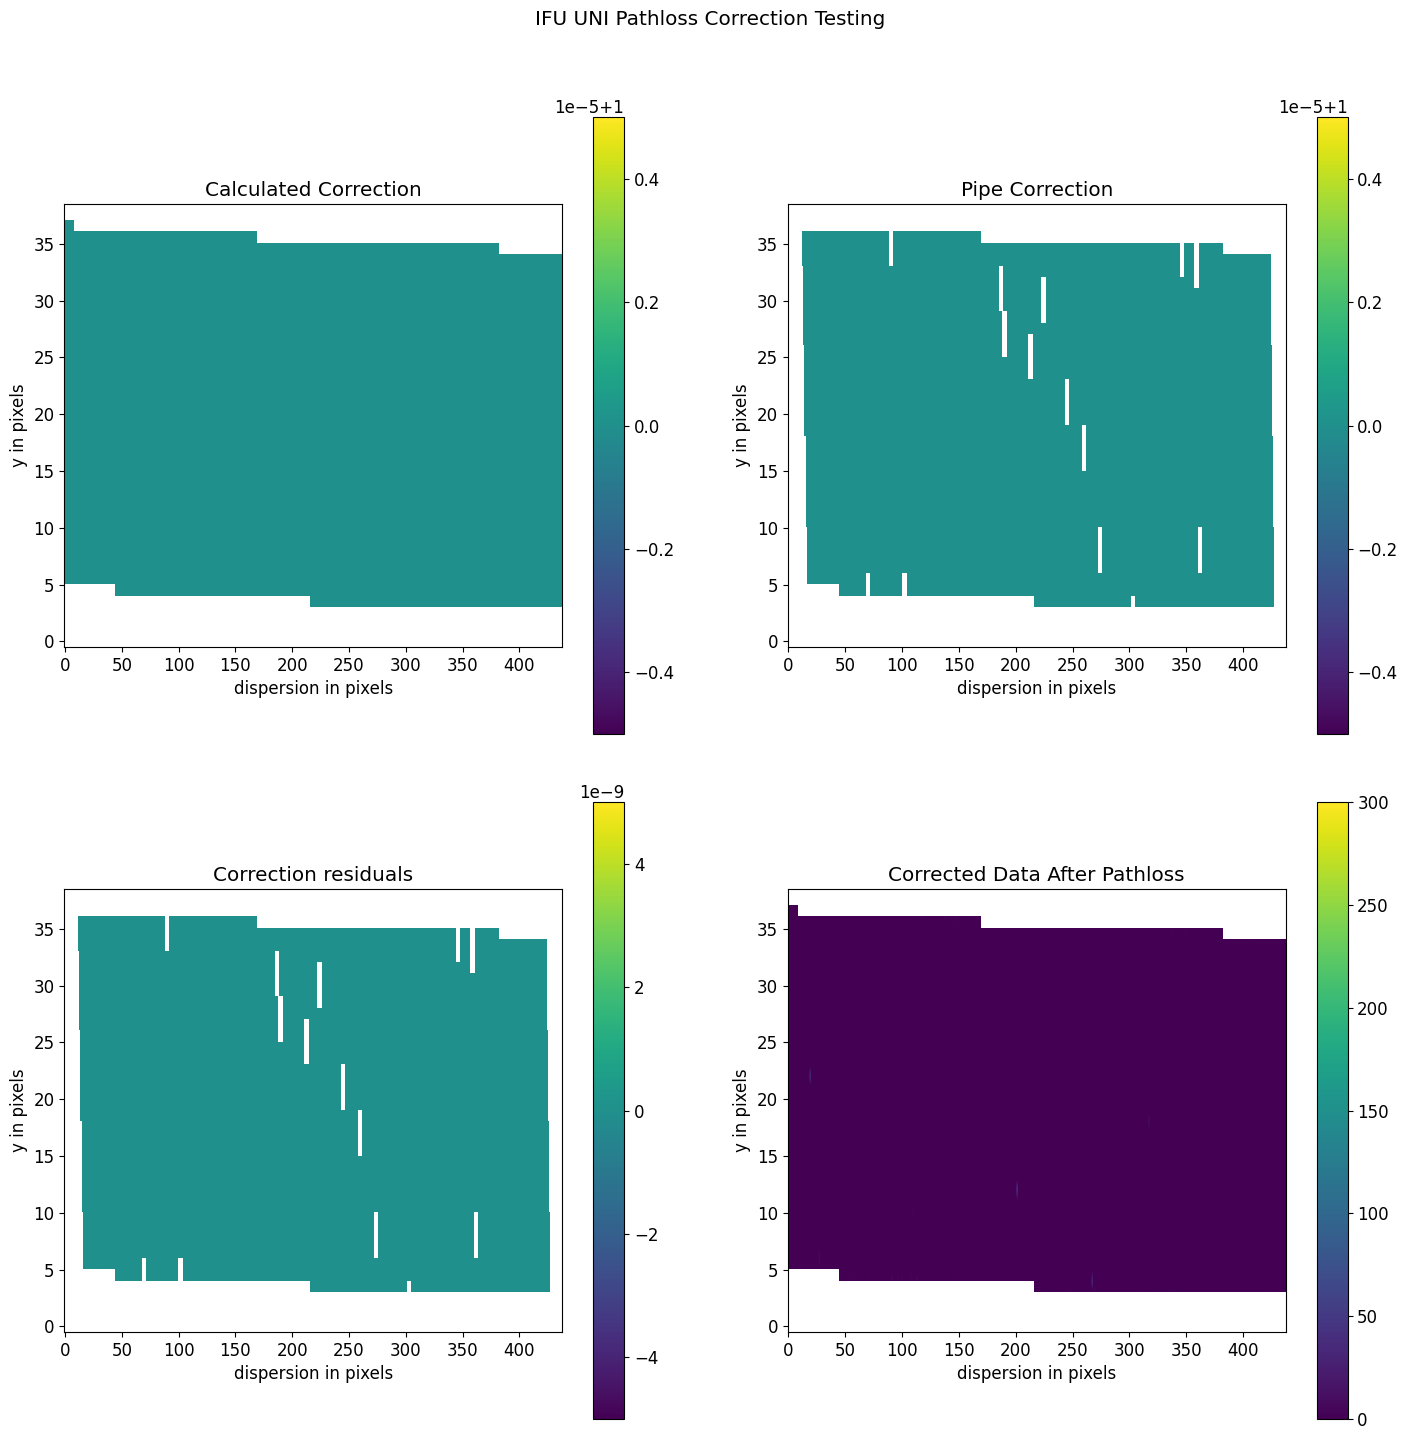

working with slice 1
SHAPES (41, 441) (40, 442)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 1197, right 1237, top 946, bottom 504
NEW SHAPE OF SLICE: (40, 442) and corr_vals.shape: (40, 442)


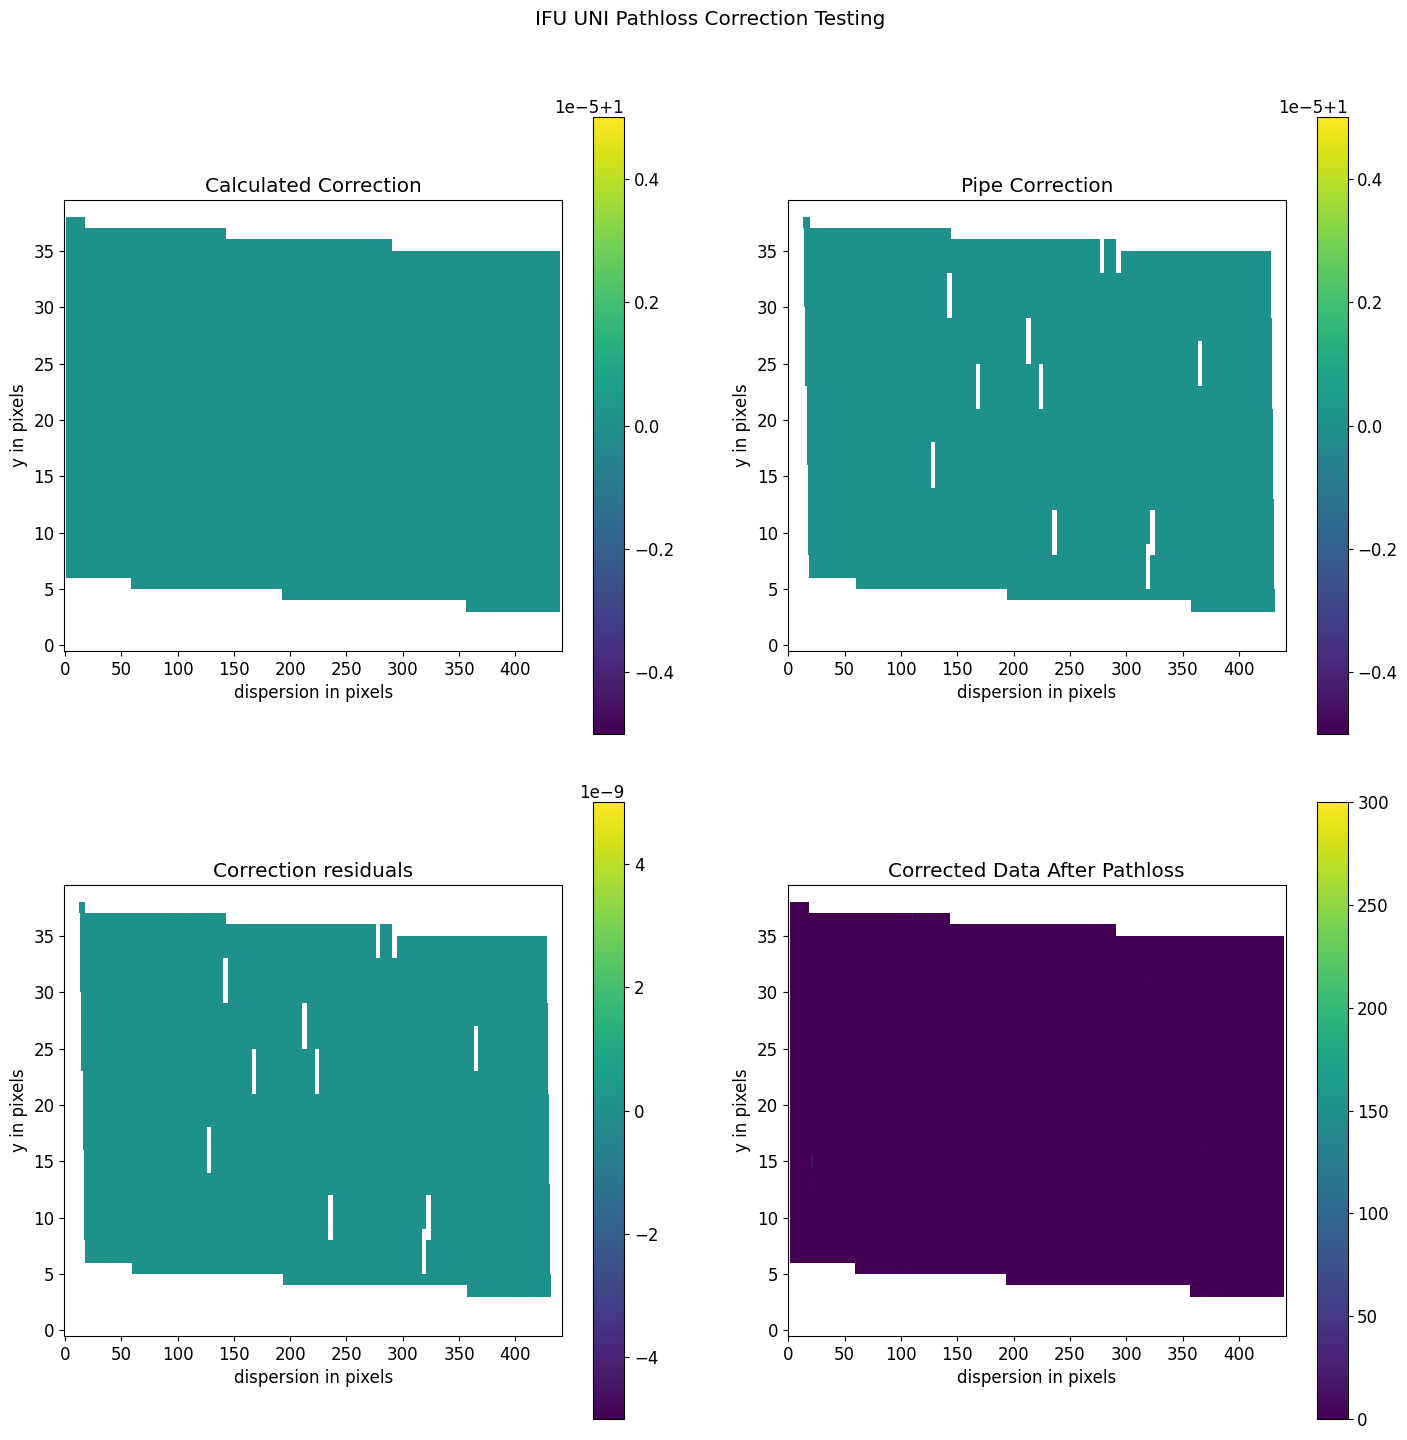

working with slice 2
SHAPES (40, 438) (39, 438)
ALTERED SHAPE OF SLICE: V2
final left 730, right 769, top 1005, bottom 567
NEW SHAPE OF SLICE: (39, 438) and corr_vals.shape: (39, 438)


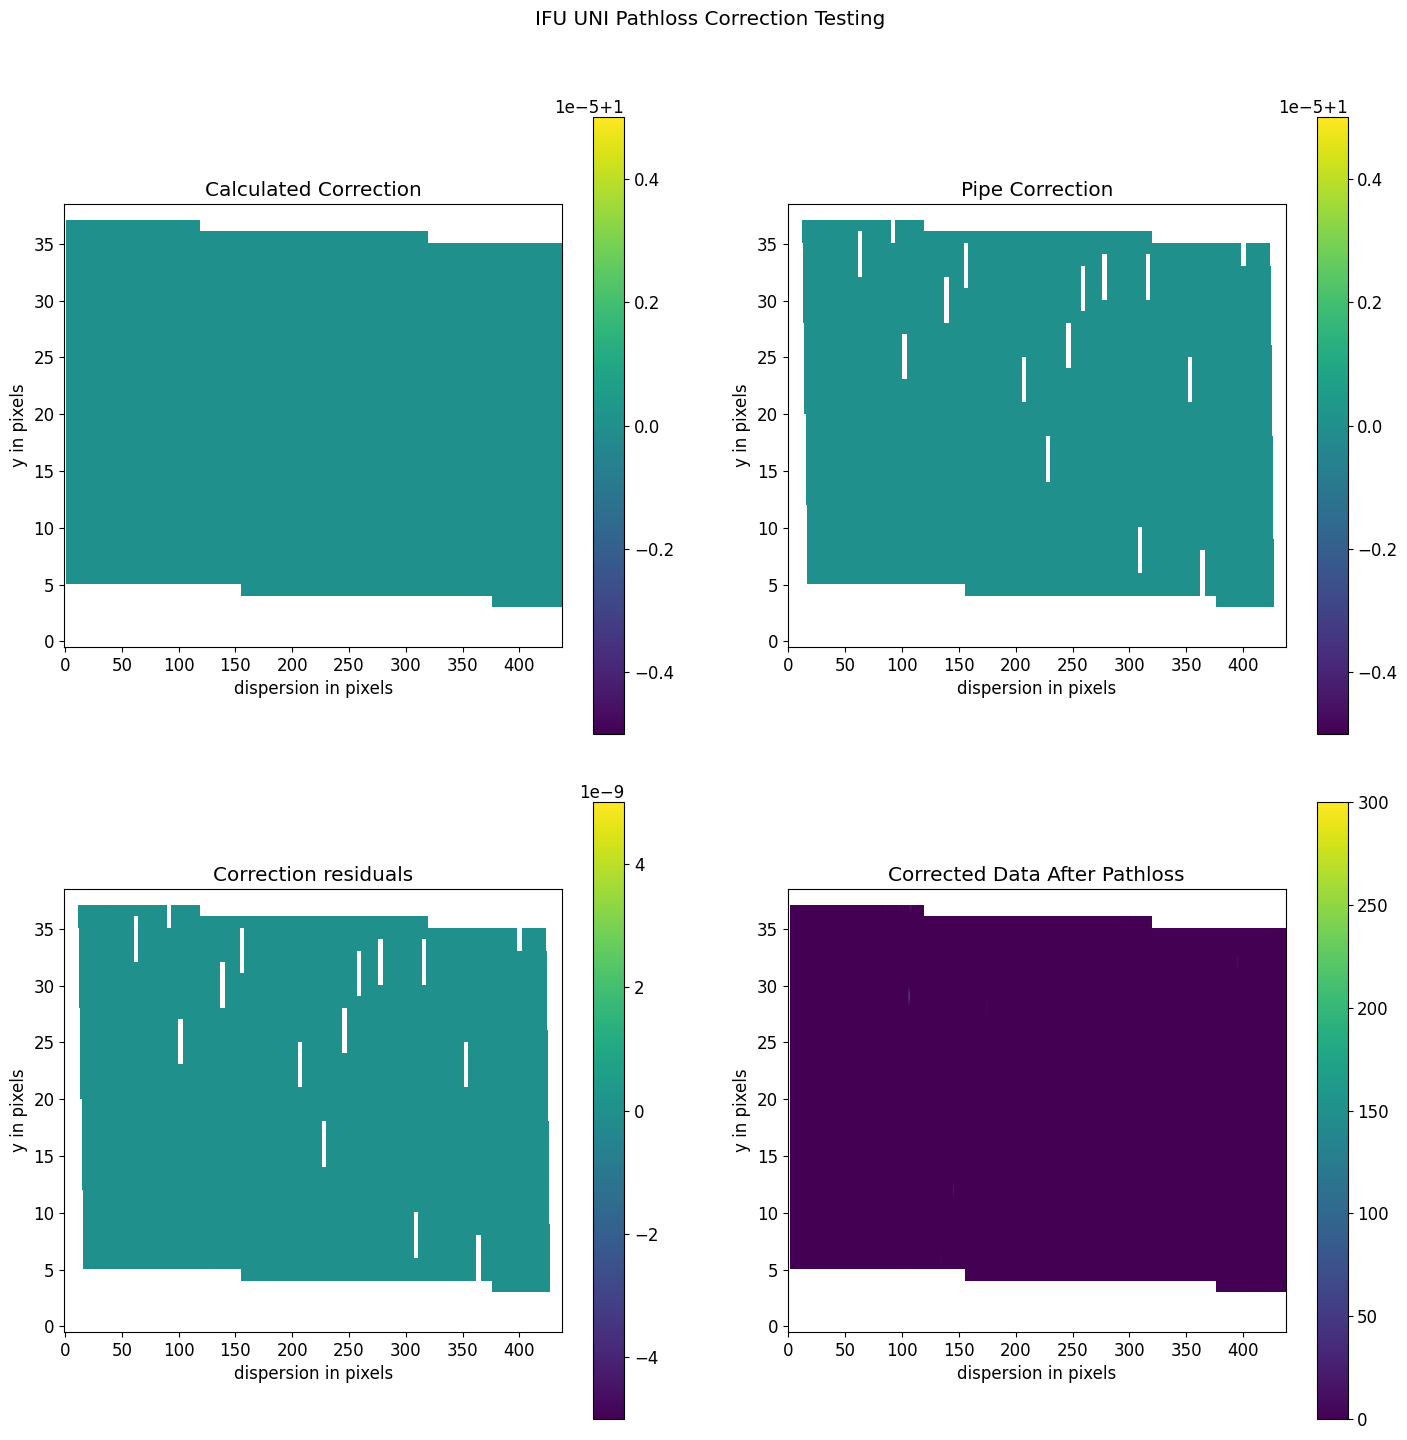

working with slice 3
SHAPES (41, 442) (40, 442)
ALTERED SHAPE OF SLICE: V2
final left 1246, right 1286, top 940, bottom 498
NEW SHAPE OF SLICE: (40, 442) and corr_vals.shape: (40, 442)


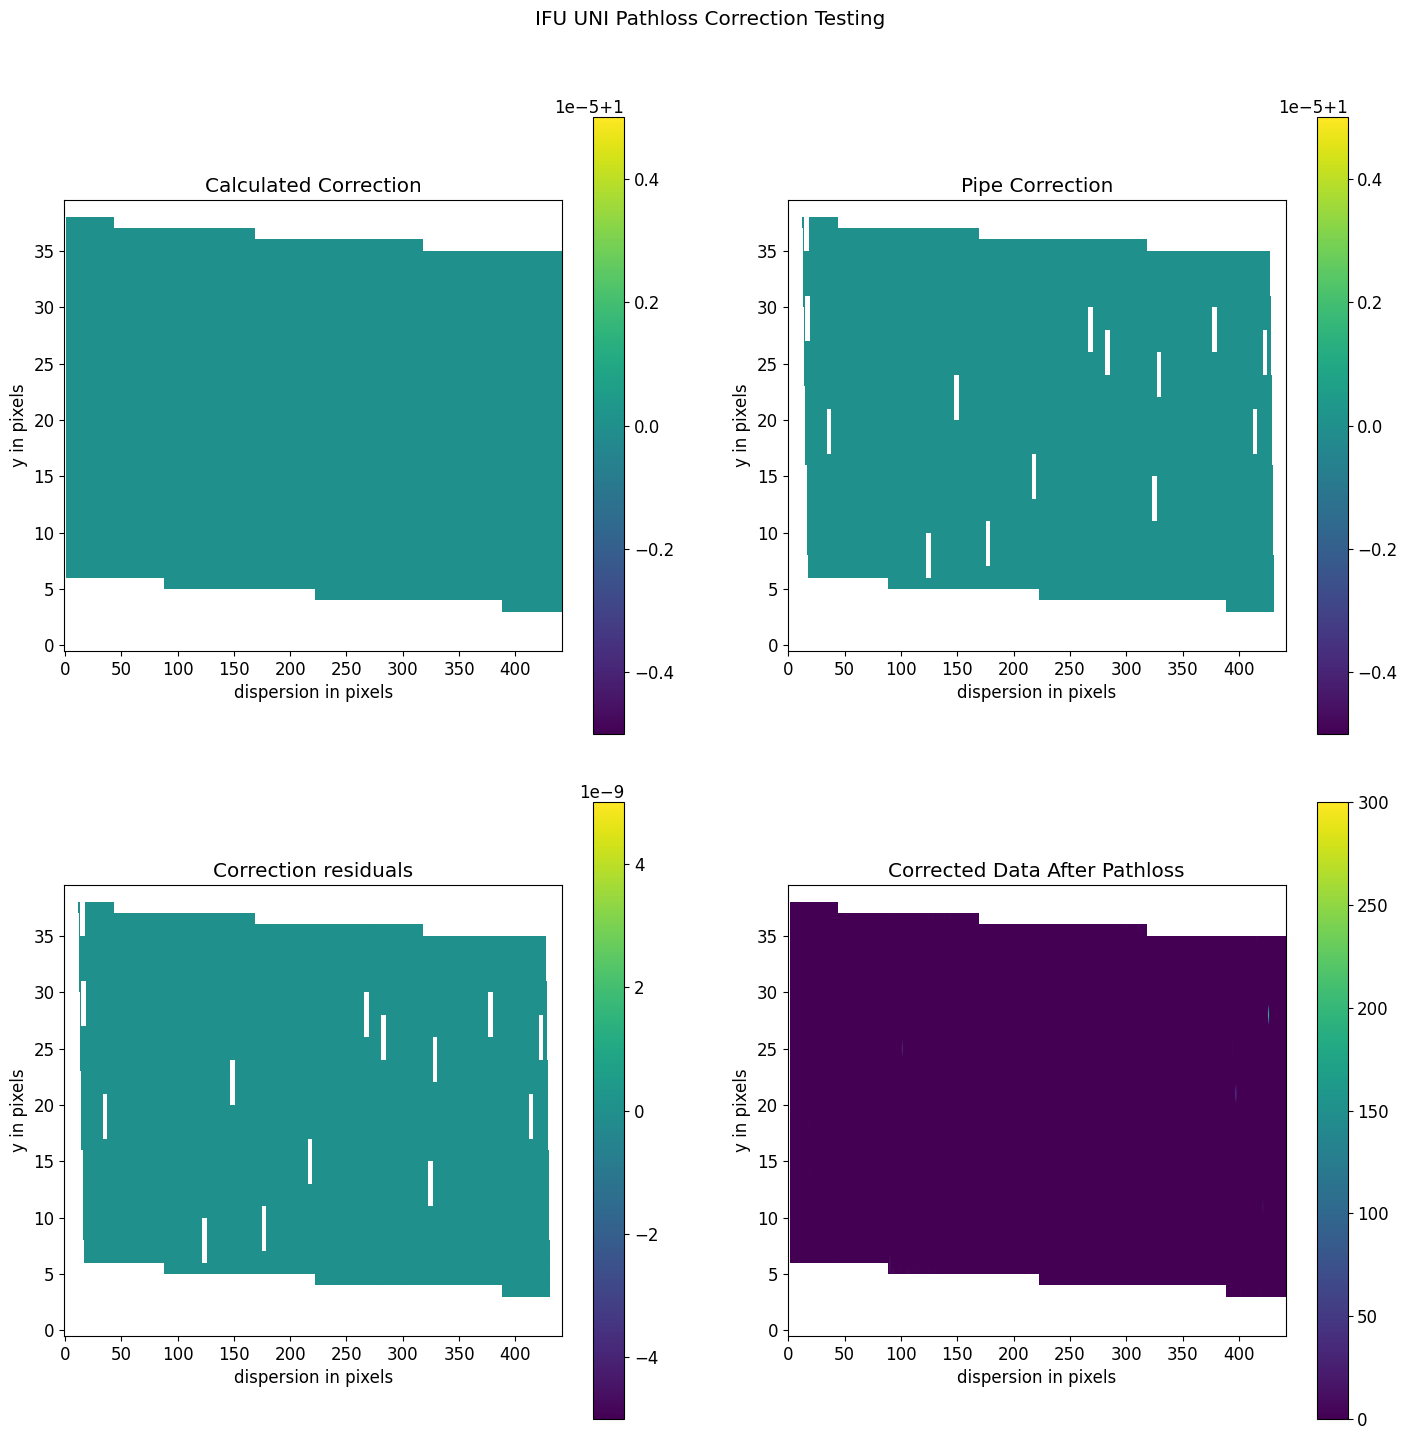

working with slice 4
SHAPES (40, 437) (39, 438)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 681, right 720, top 1010, bottom 572
NEW SHAPE OF SLICE: (39, 438) and corr_vals.shape: (39, 438)


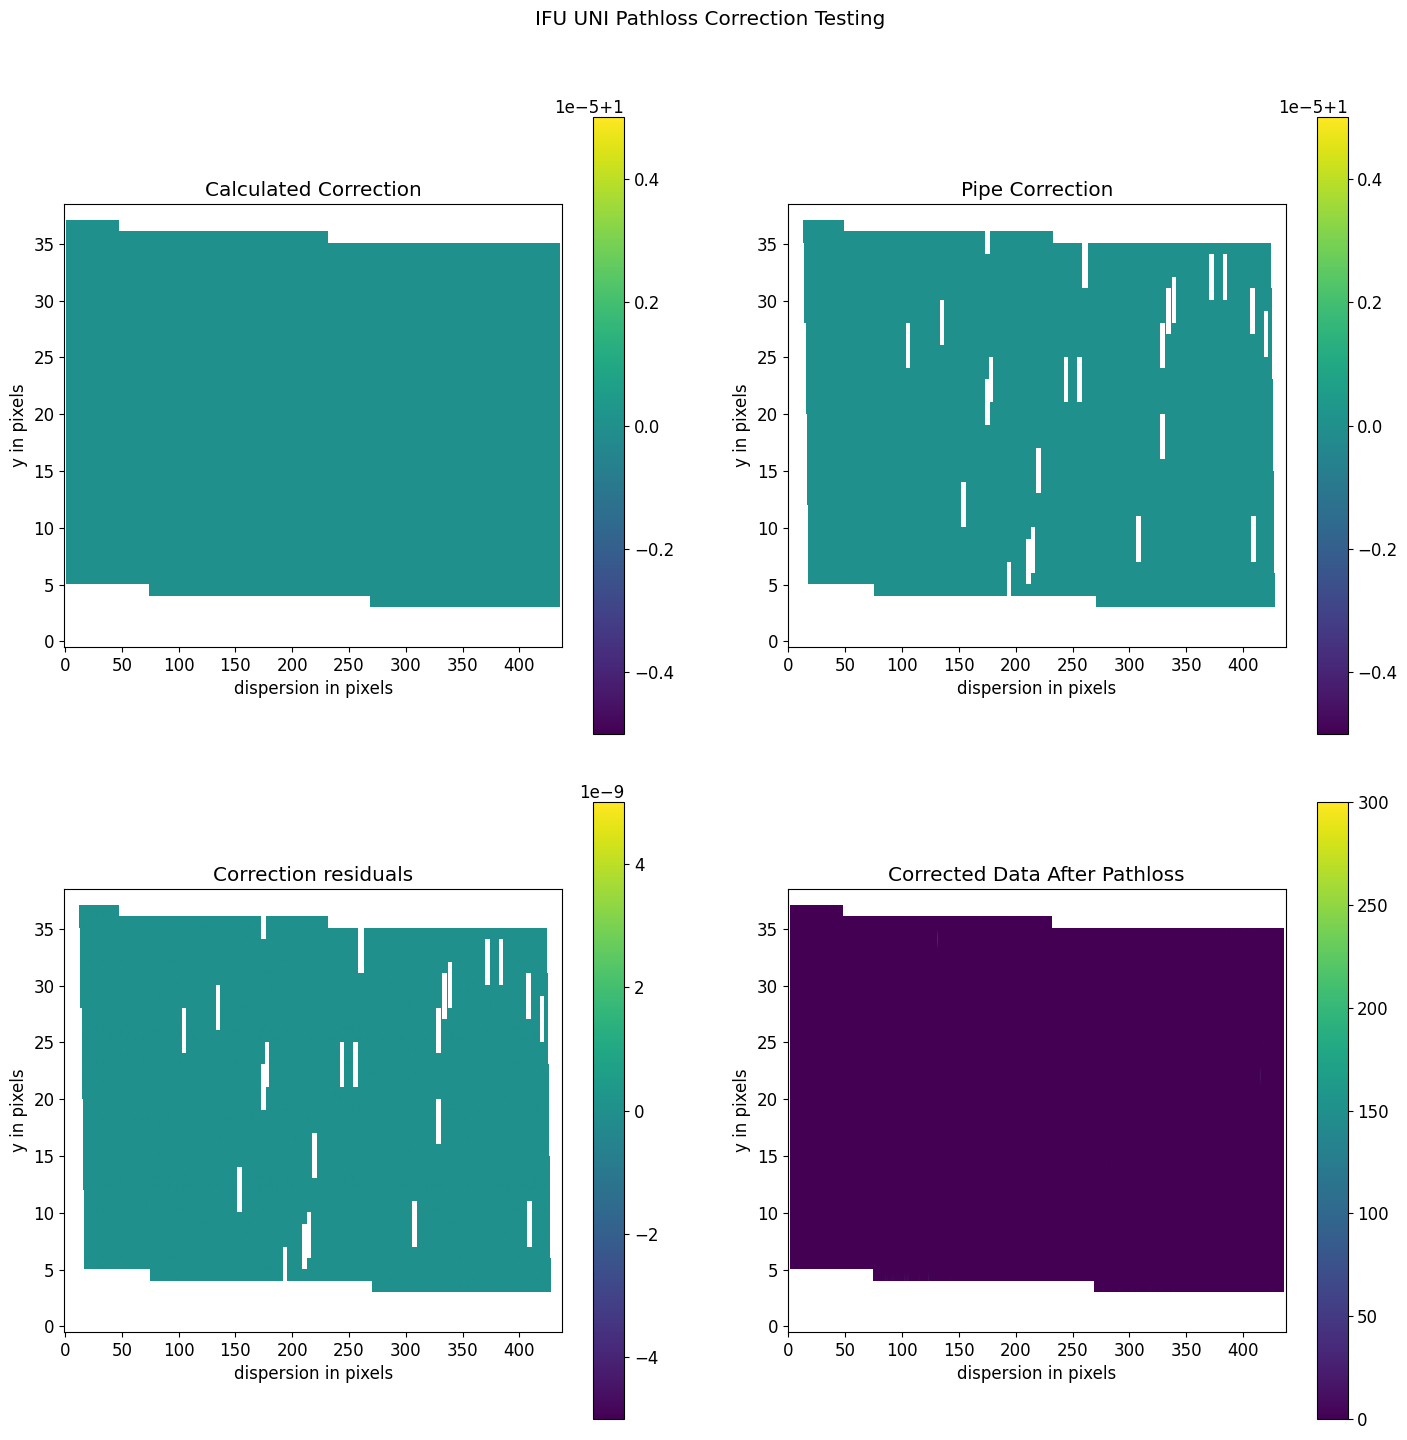

working with slice 5
SHAPES (41, 442) (40, 442)
ALTERED SHAPE OF SLICE: V2
final left 1295, right 1335, top 933, bottom 491
NEW SHAPE OF SLICE: (40, 442) and corr_vals.shape: (40, 442)


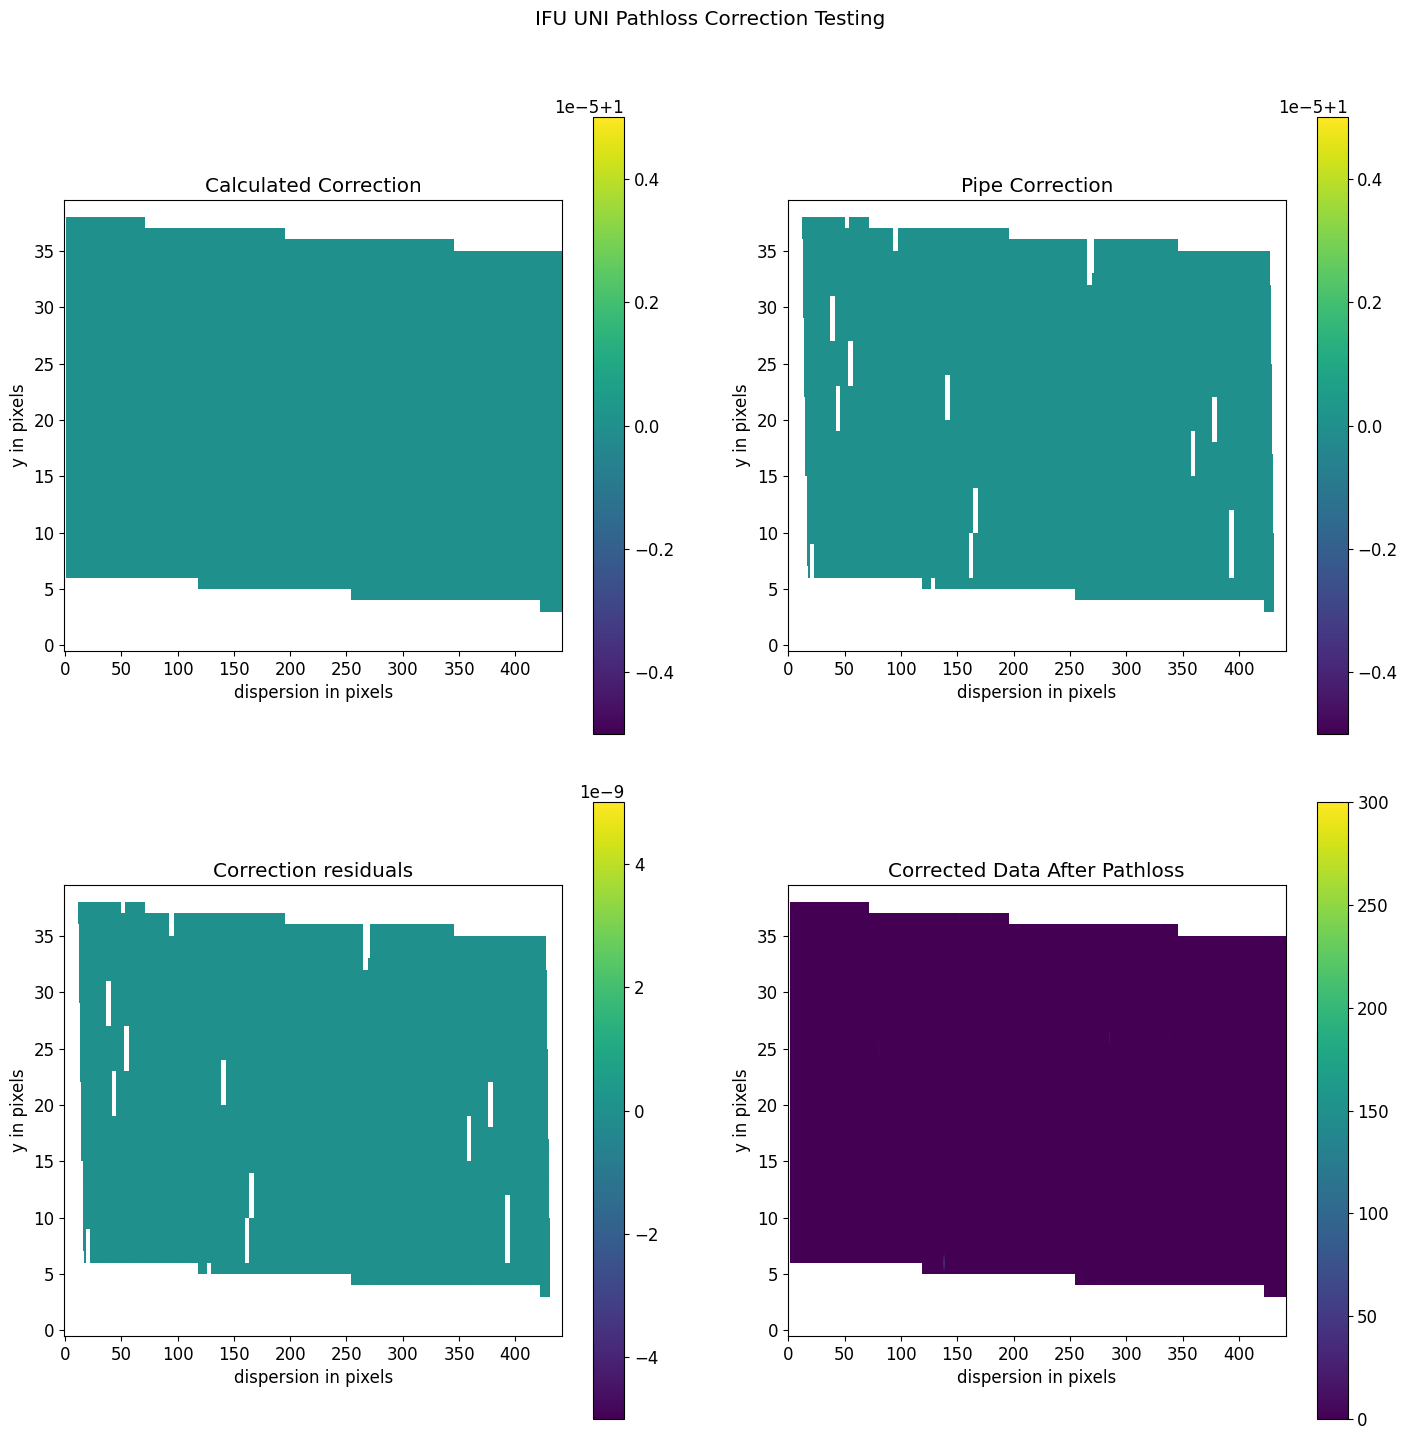

working with slice 6
SHAPES (40, 437) (39, 438)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 632, right 671, top 1016, bottom 578
NEW SHAPE OF SLICE: (39, 438) and corr_vals.shape: (39, 438)


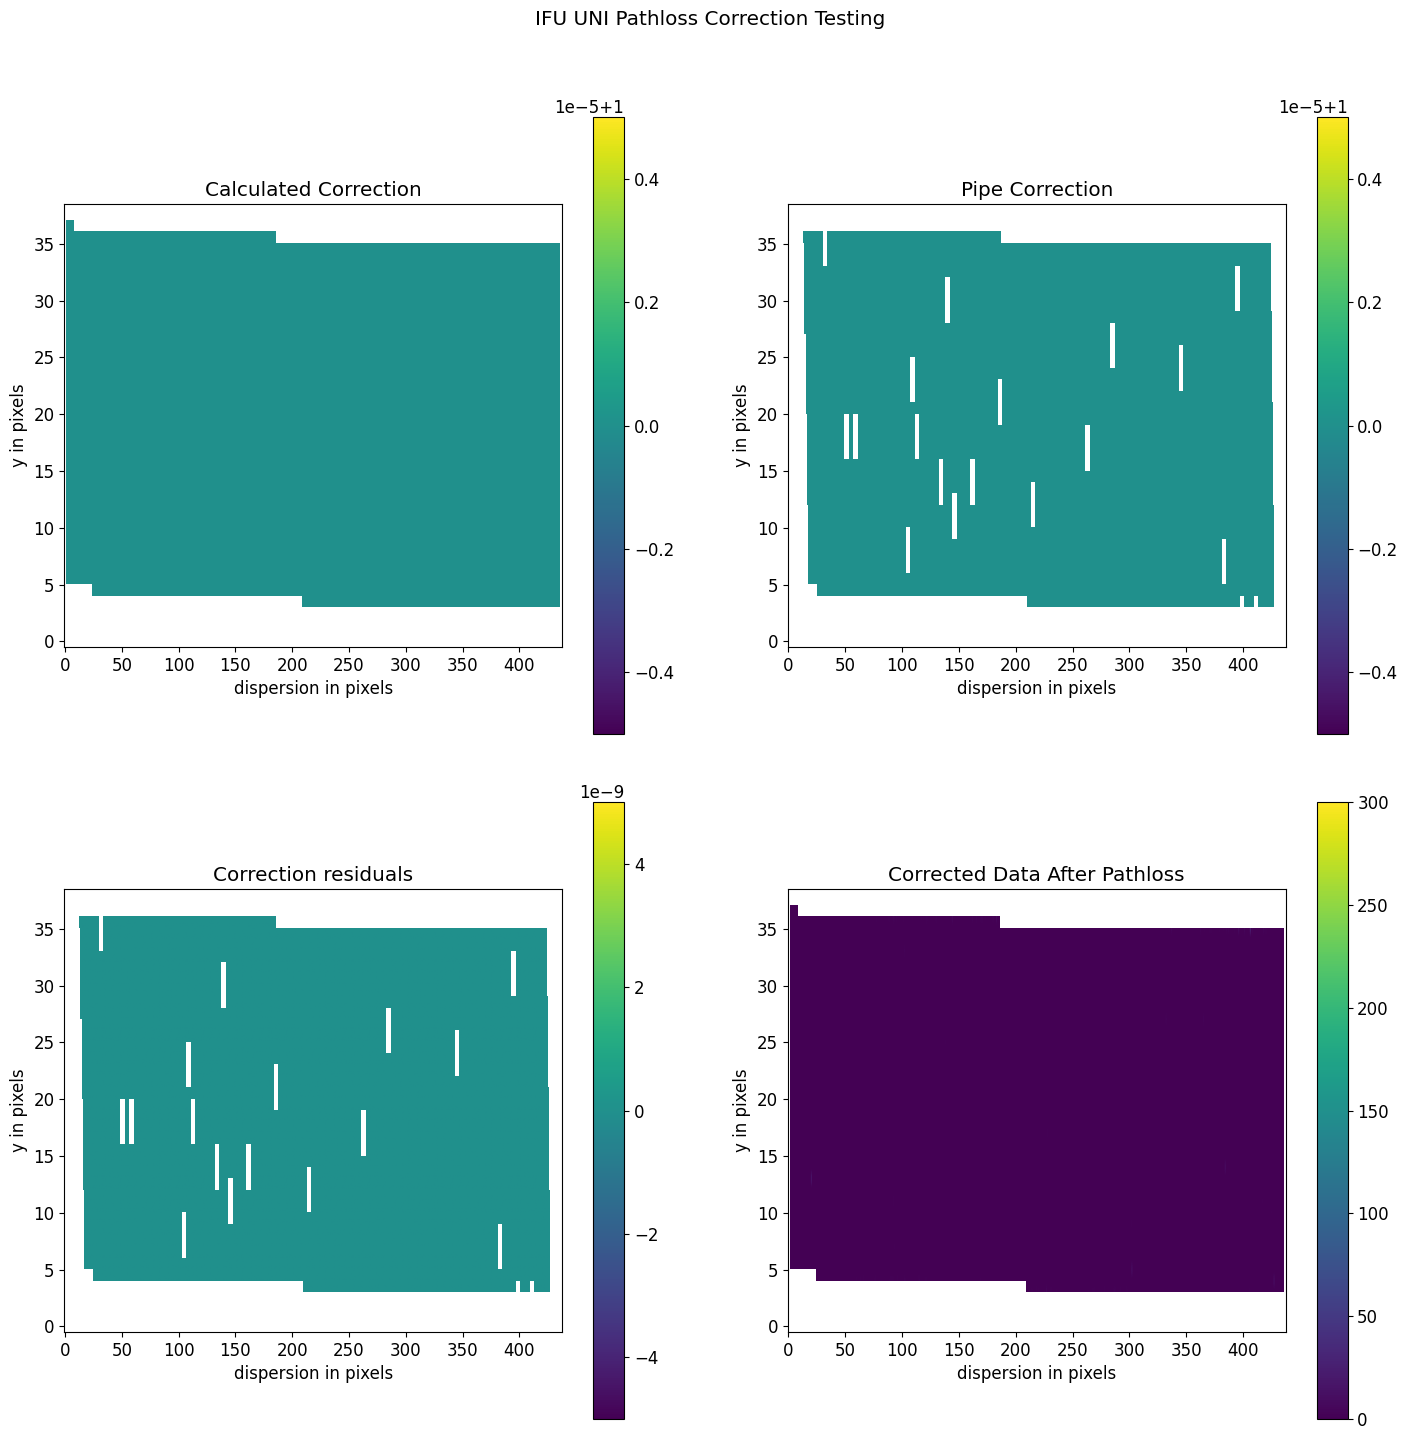

working with slice 7
SHAPES (40, 443) (39, 443)
ALTERED SHAPE OF SLICE: V2
final left 1345, right 1384, top 926, bottom 483
NEW SHAPE OF SLICE: (39, 443) and corr_vals.shape: (39, 443)


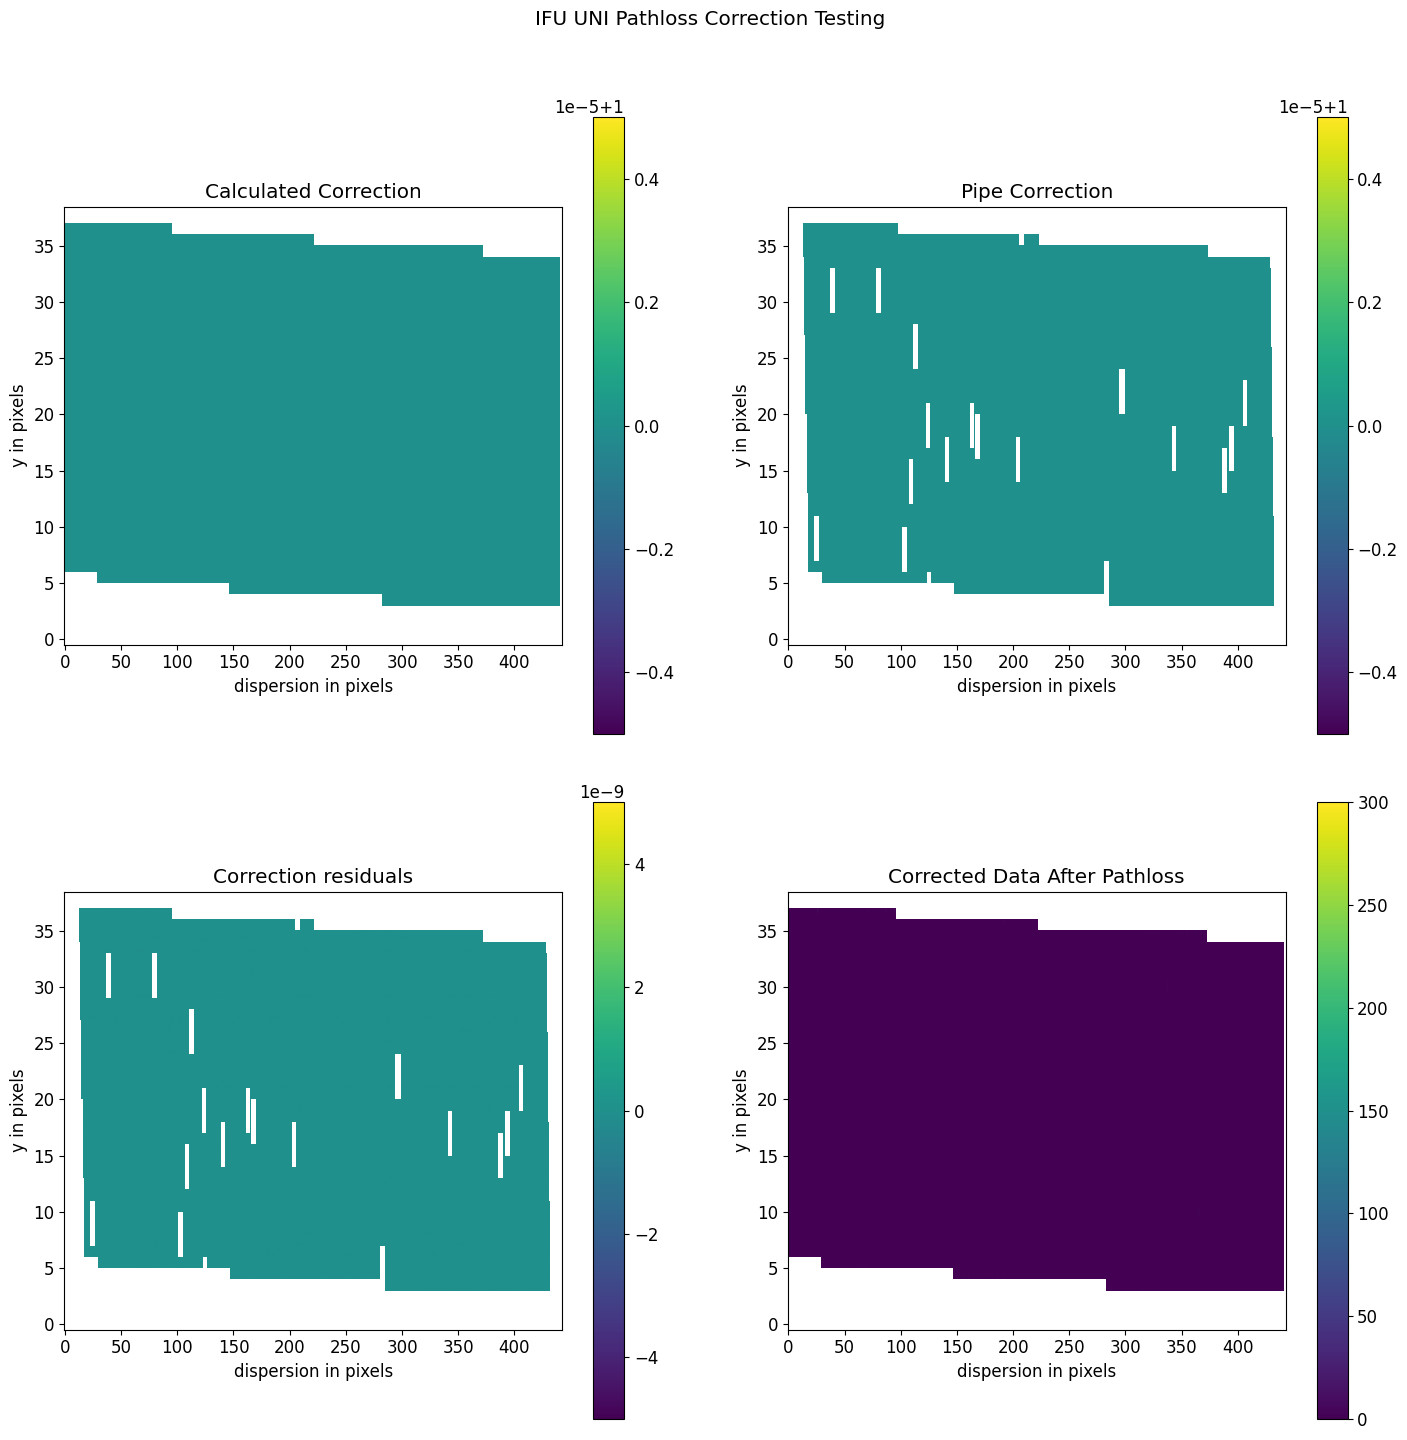

working with slice 8
SHAPES (40, 437) (39, 437)
ALTERED SHAPE OF SLICE: V2
final left 582, right 621, top 1022, bottom 585
NEW SHAPE OF SLICE: (39, 437) and corr_vals.shape: (39, 437)


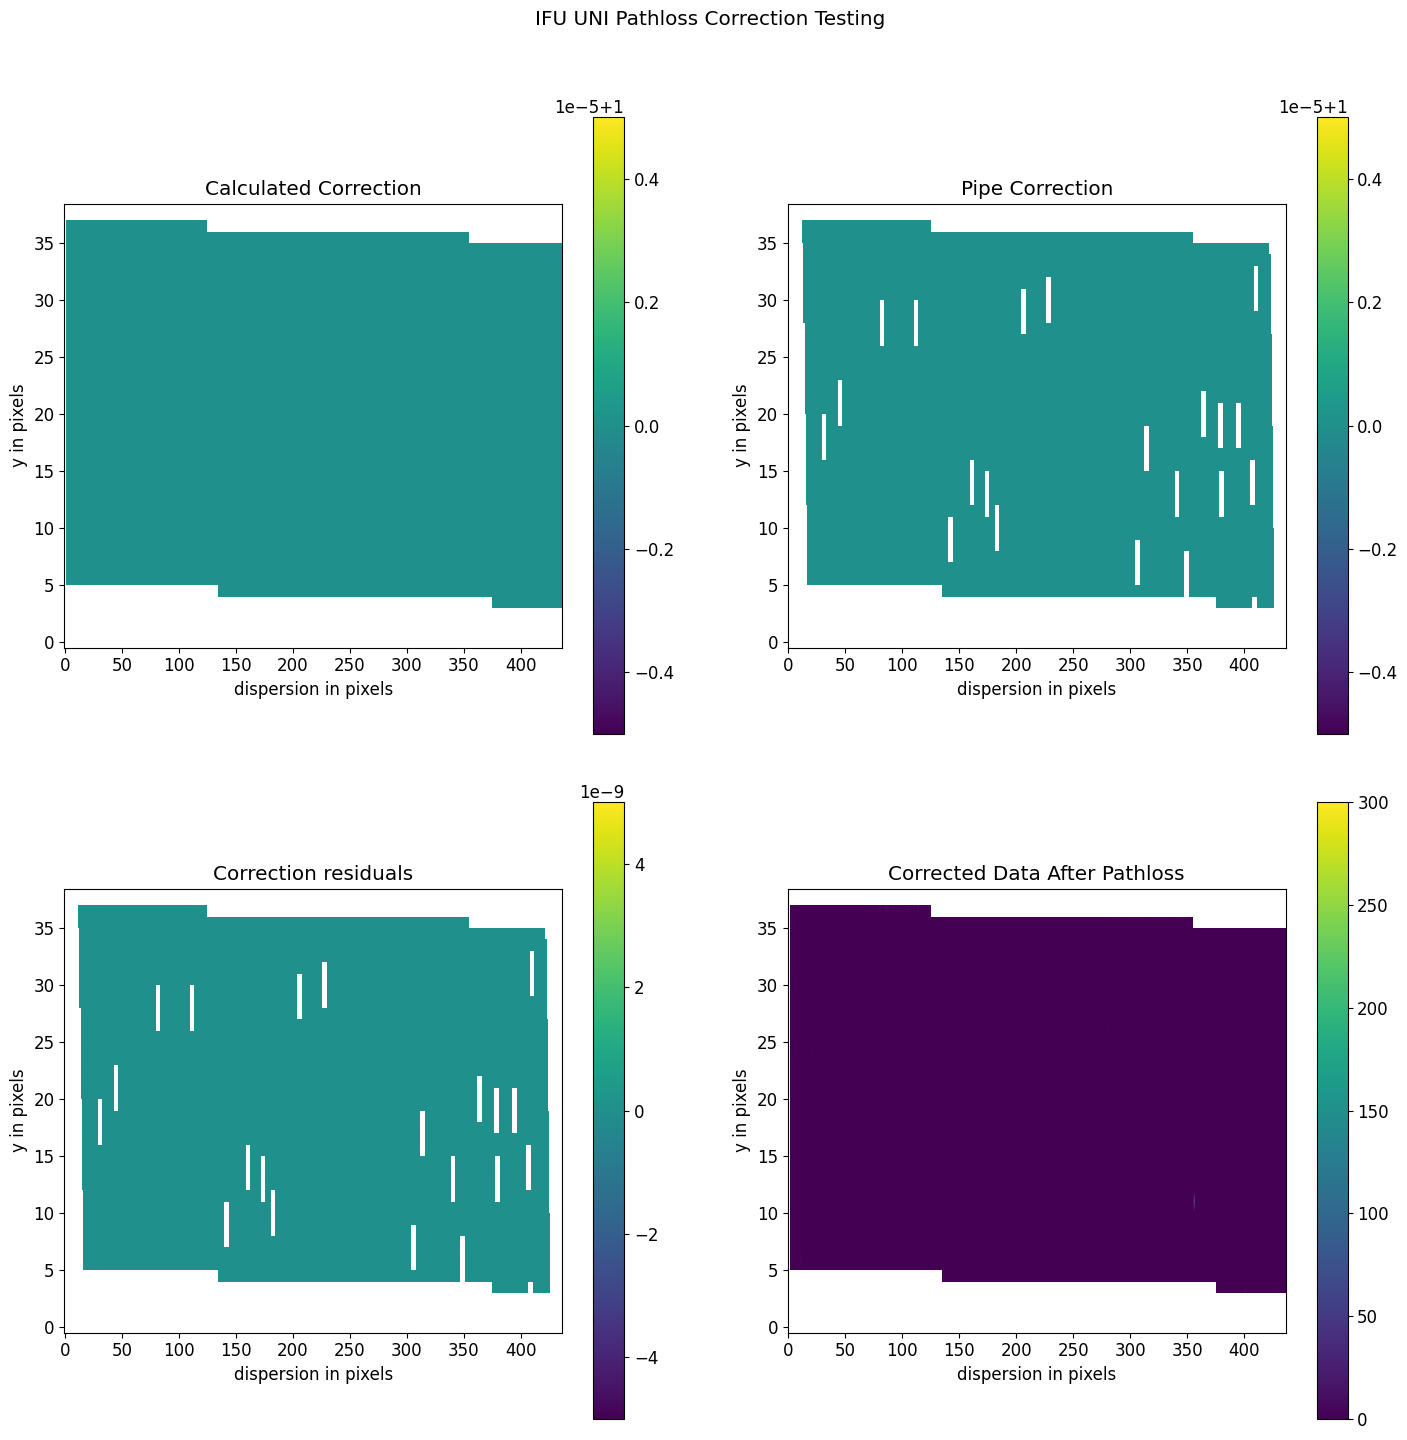

working with slice 9
SHAPES (41, 443) (40, 443)
ALTERED SHAPE OF SLICE: V2
final left 1394, right 1434, top 919, bottom 476
NEW SHAPE OF SLICE: (40, 443) and corr_vals.shape: (40, 443)


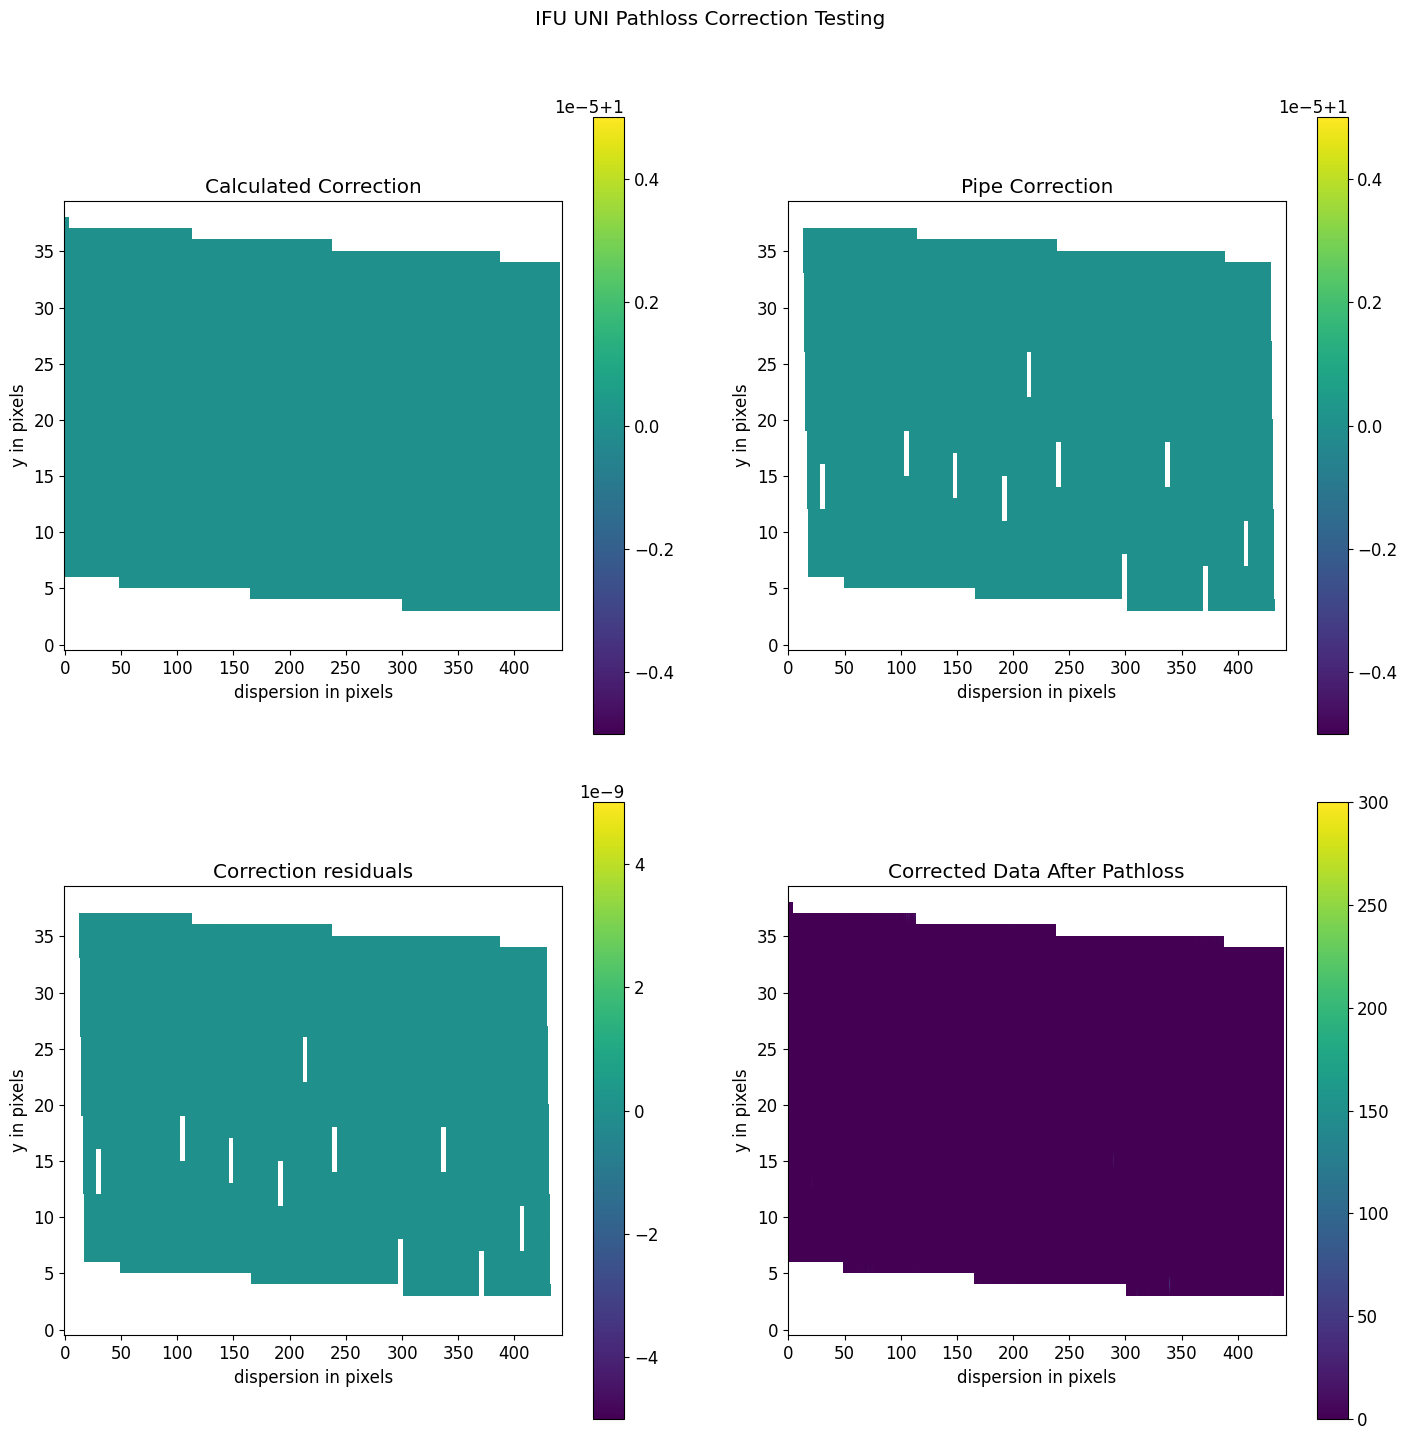

working with slice 10
SHAPES (40, 436) (39, 437)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 533, right 572, top 1027, bottom 590
NEW SHAPE OF SLICE: (39, 437) and corr_vals.shape: (39, 437)


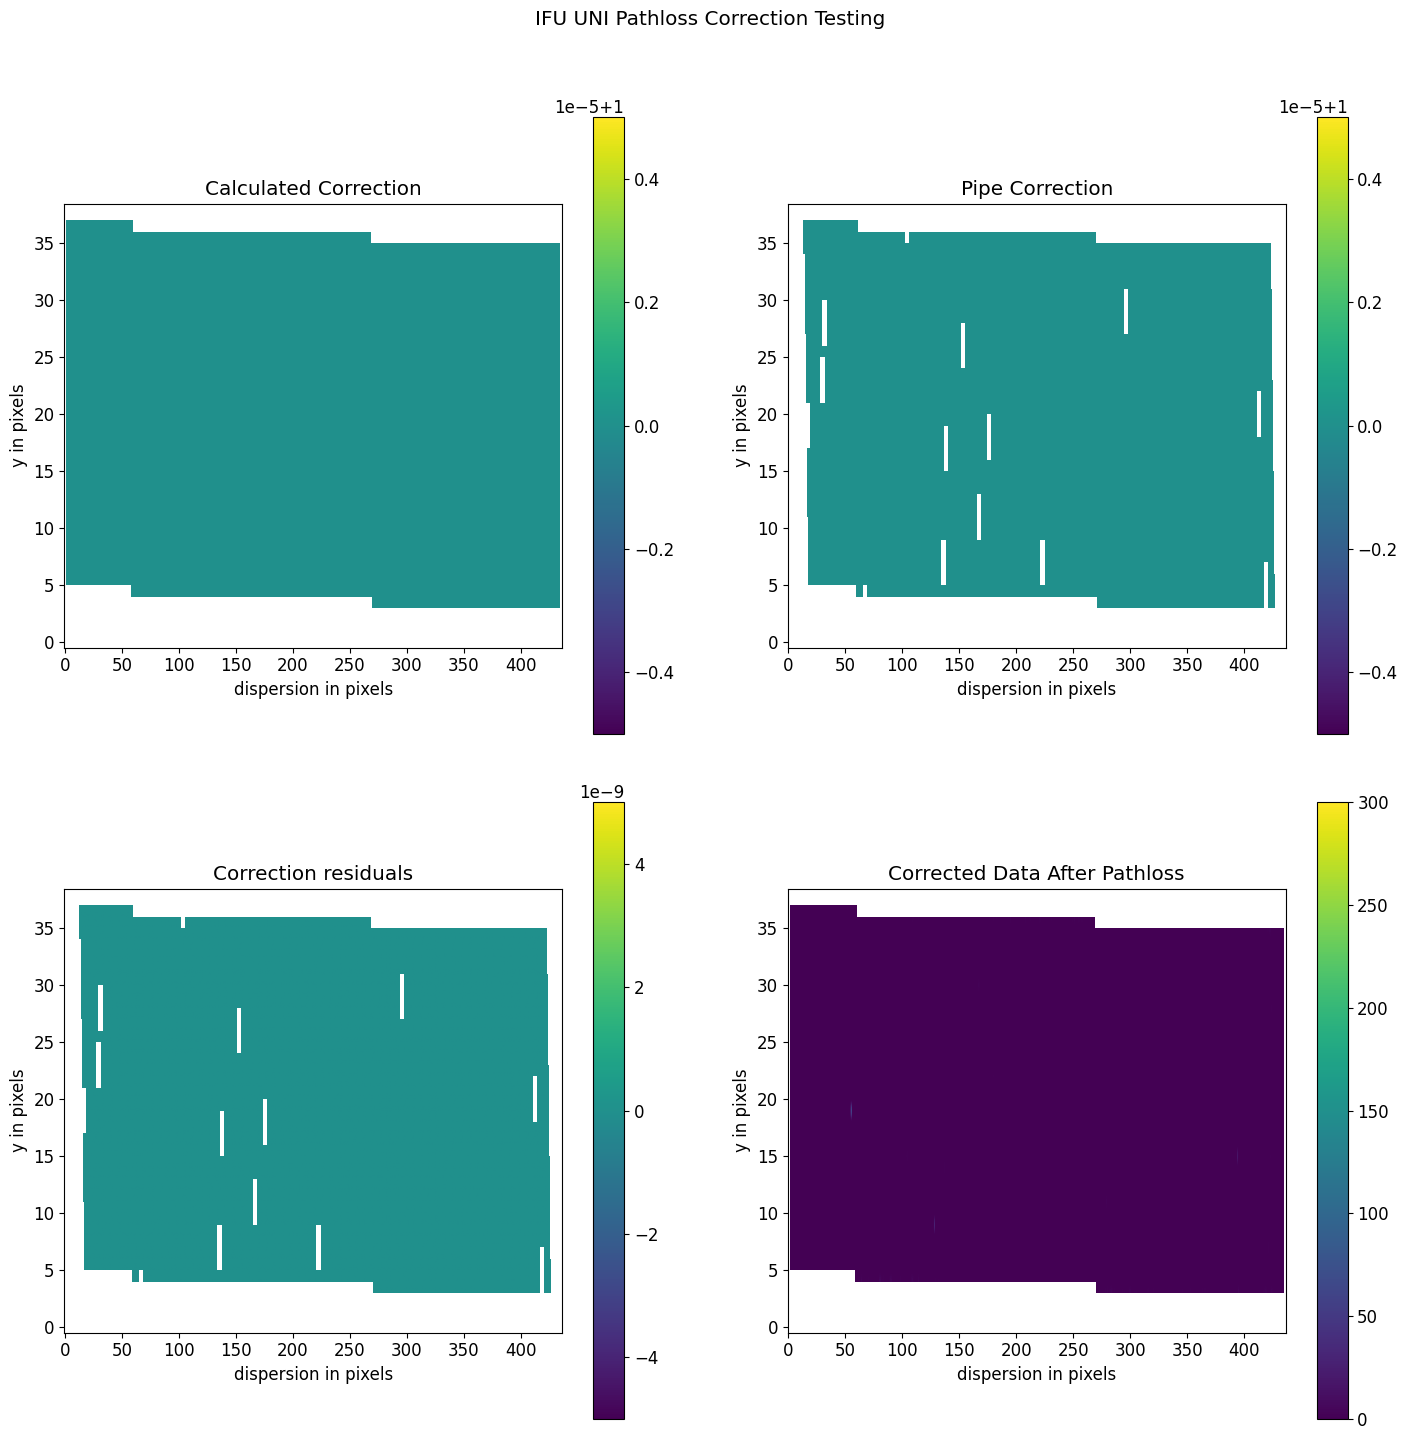

working with slice 11
SHAPES (41, 443) (40, 444)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 1443, right 1483, top 912, bottom 468
NEW SHAPE OF SLICE: (40, 444) and corr_vals.shape: (40, 444)


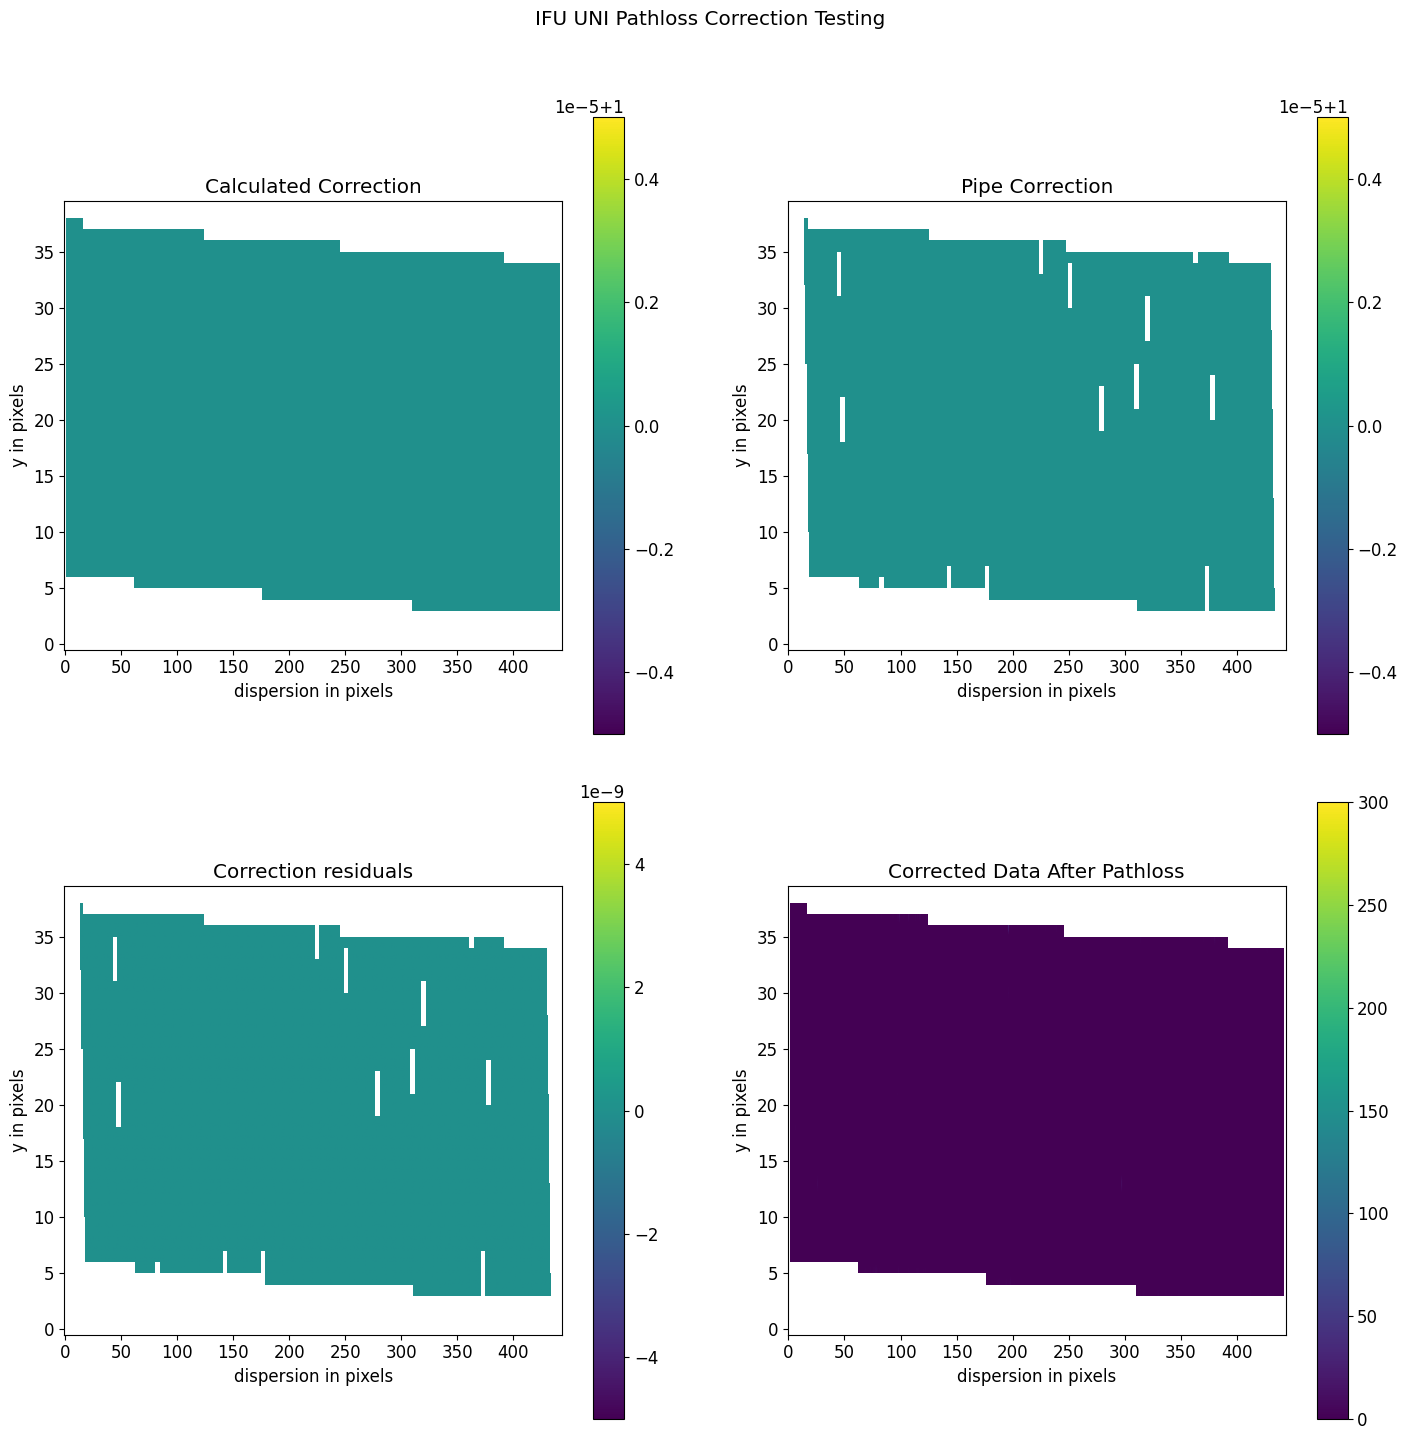

working with slice 12
SHAPES (40, 437) (39, 436)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V6
final left 484, right 523, top 1033, bottom 597
NEW SHAPE OF SLICE: (39, 436) and corr_vals.shape: (39, 436)


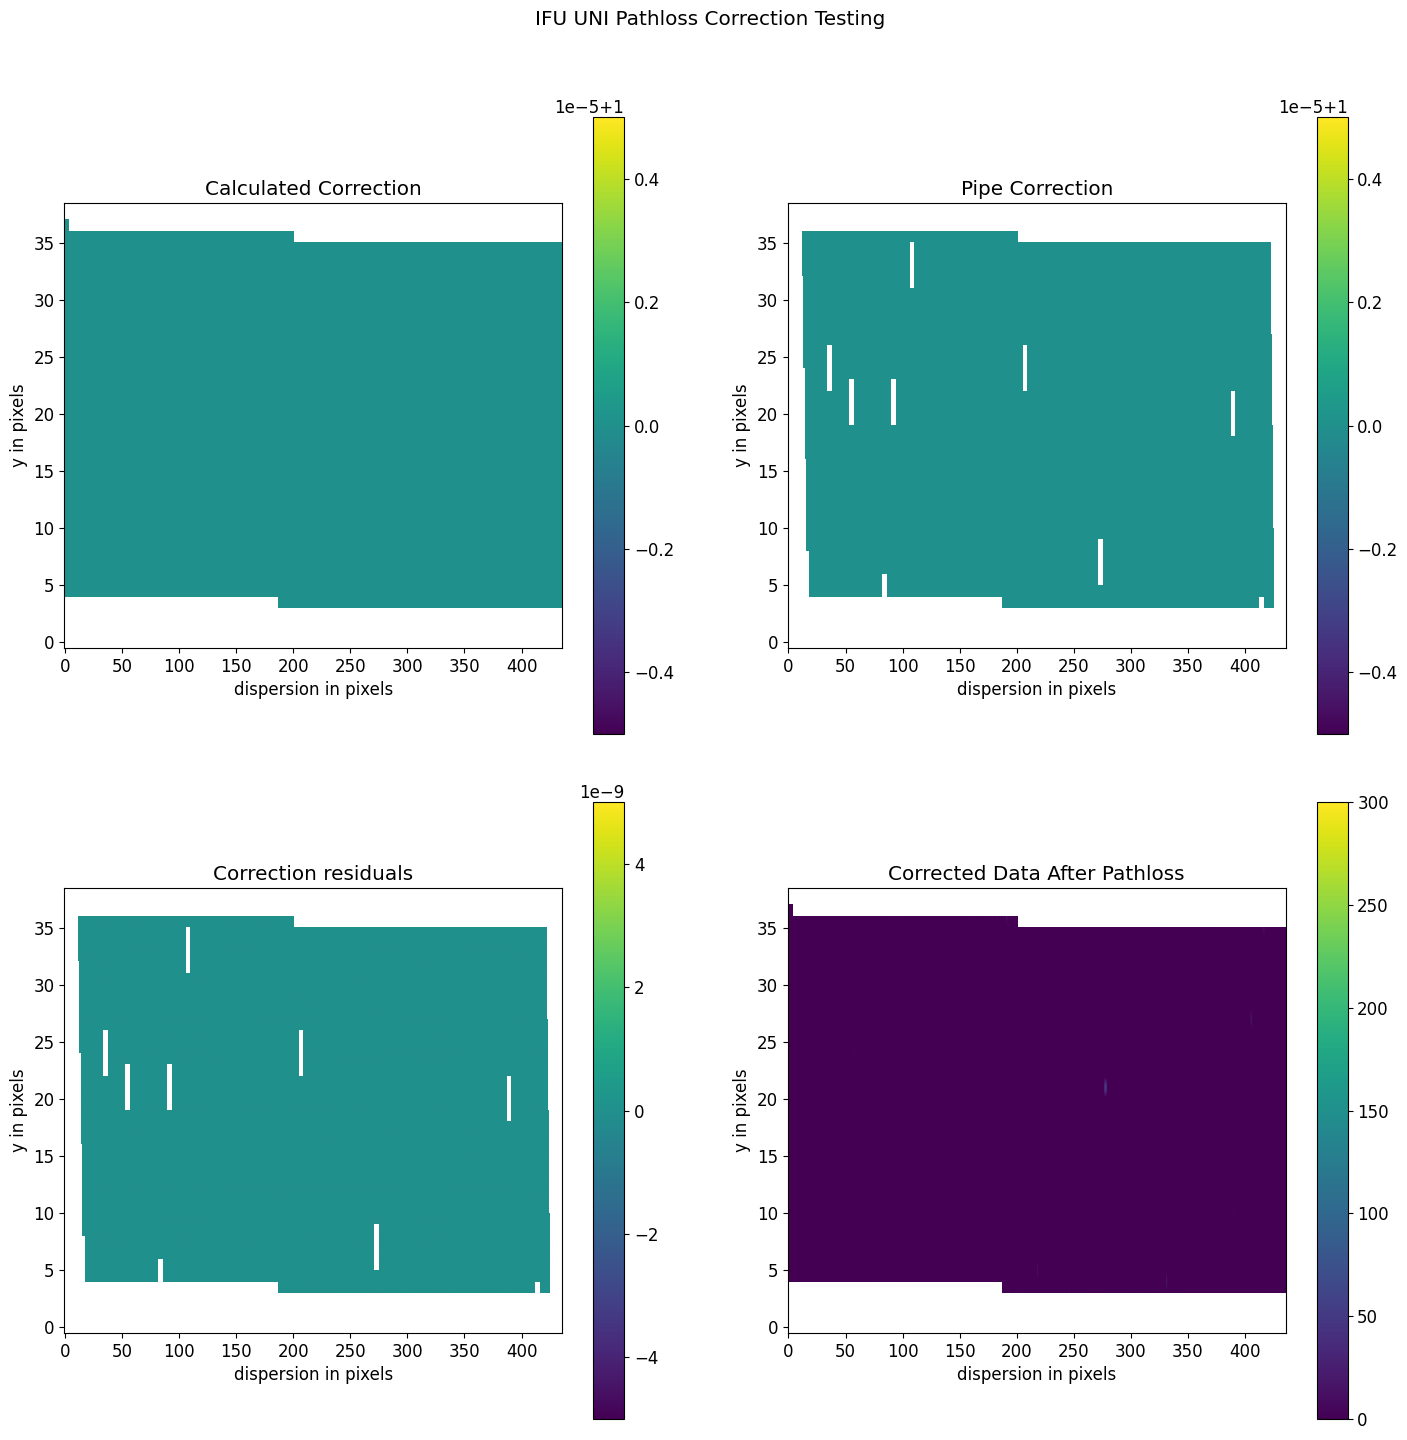

working with slice 13
SHAPES (41, 443) (40, 444)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 1492, right 1532, top 905, bottom 461
NEW SHAPE OF SLICE: (40, 444) and corr_vals.shape: (40, 444)


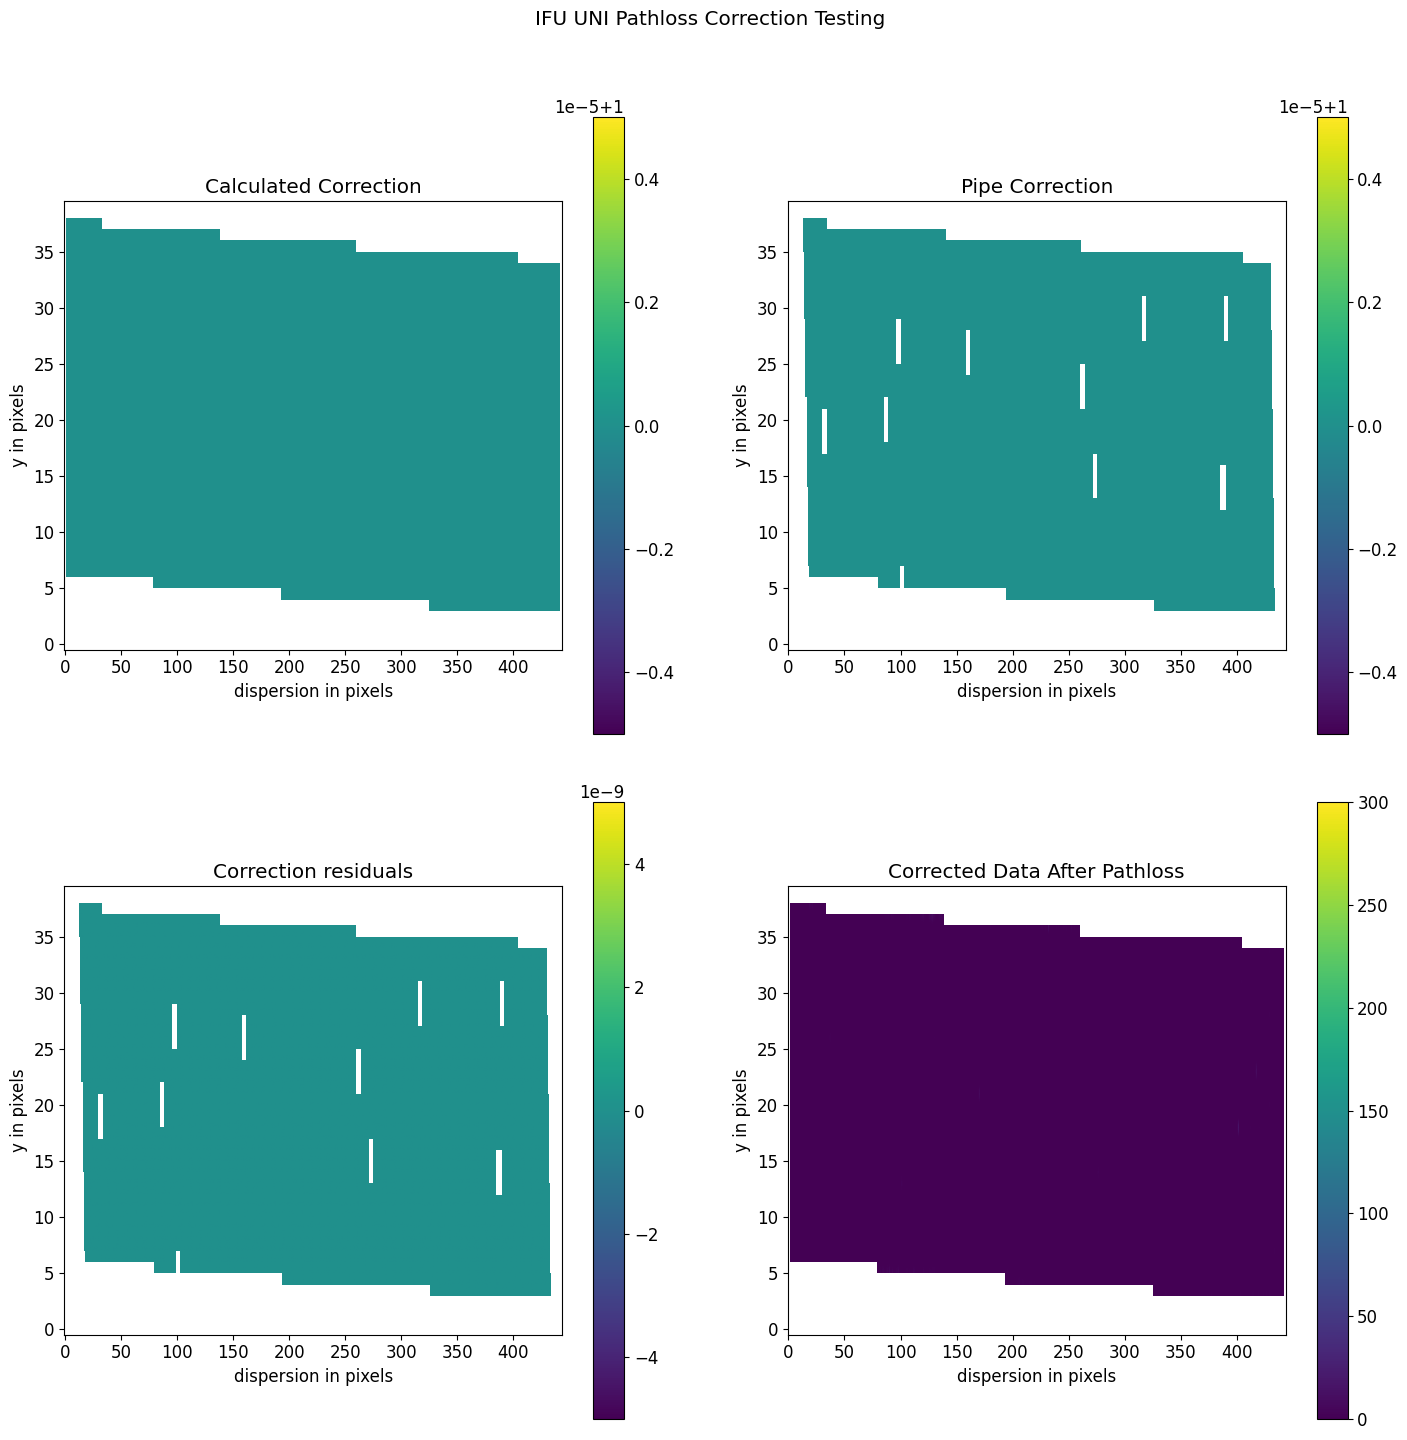

working with slice 14
SHAPES (40, 436) (39, 436)
ALTERED SHAPE OF SLICE: V2
final left 434, right 473, top 1038, bottom 602
NEW SHAPE OF SLICE: (39, 436) and corr_vals.shape: (39, 436)


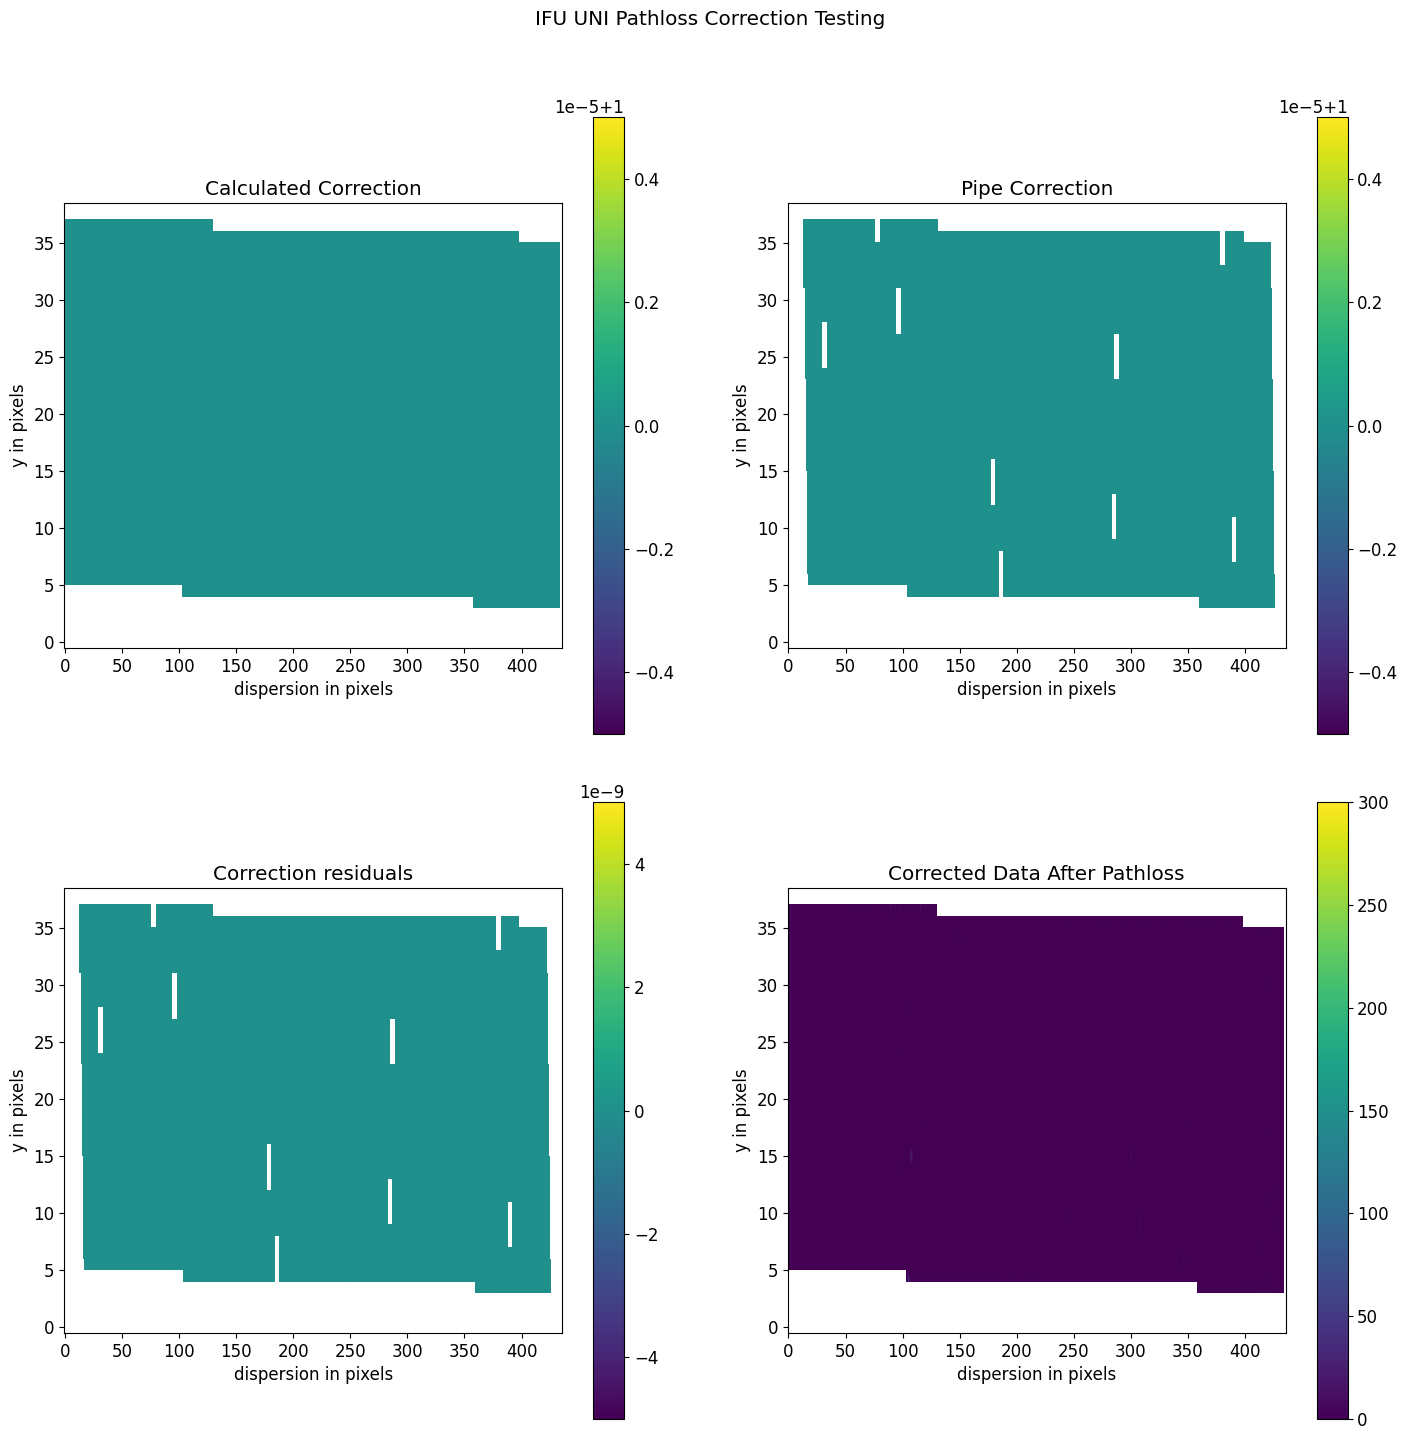

working with slice 15
SHAPES (41, 444) (40, 444)
ALTERED SHAPE OF SLICE: V2
final left 1541, right 1581, top 898, bottom 454
NEW SHAPE OF SLICE: (40, 444) and corr_vals.shape: (40, 444)


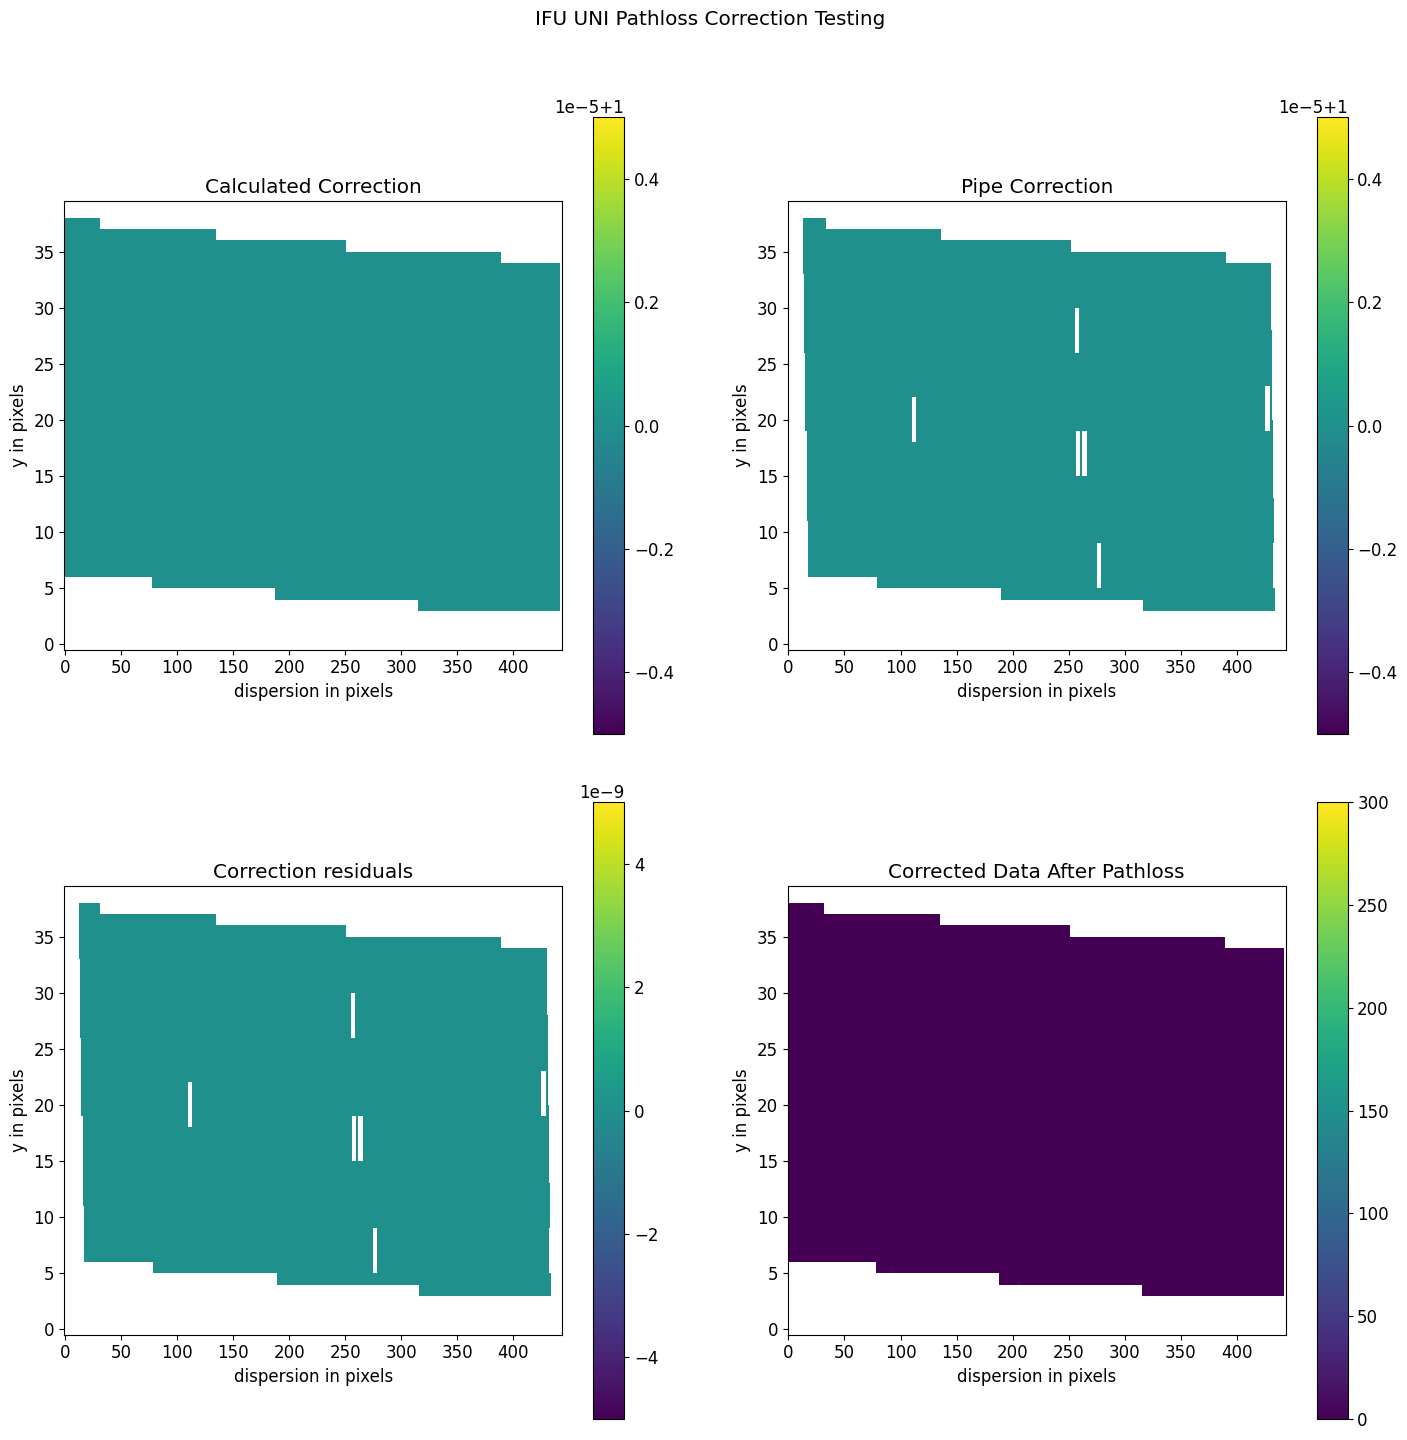

working with slice 16
SHAPES (40, 436) (39, 436)
ALTERED SHAPE OF SLICE: V2
final left 385, right 424, top 1044, bottom 608
NEW SHAPE OF SLICE: (39, 436) and corr_vals.shape: (39, 436)


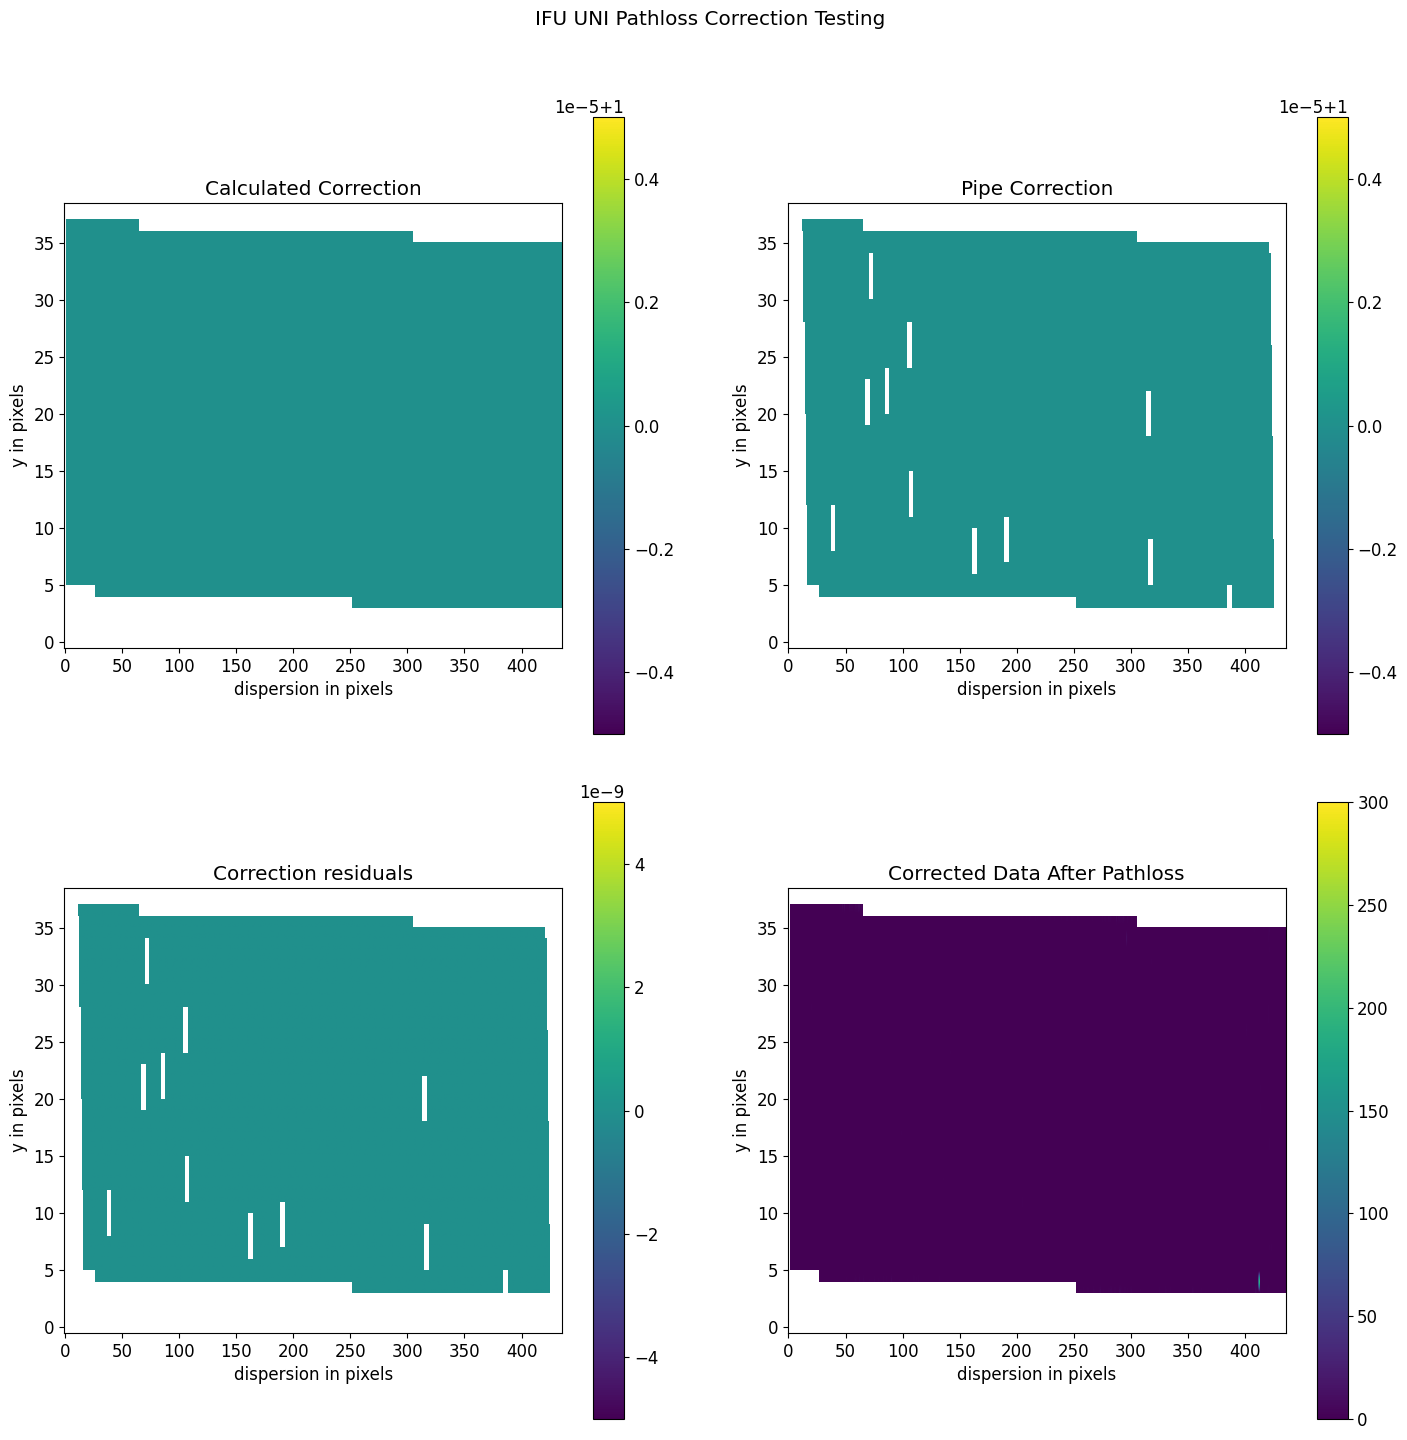

working with slice 17
SHAPES (41, 444) (40, 445)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 1590, right 1630, top 891, bottom 446
NEW SHAPE OF SLICE: (40, 445) and corr_vals.shape: (40, 445)


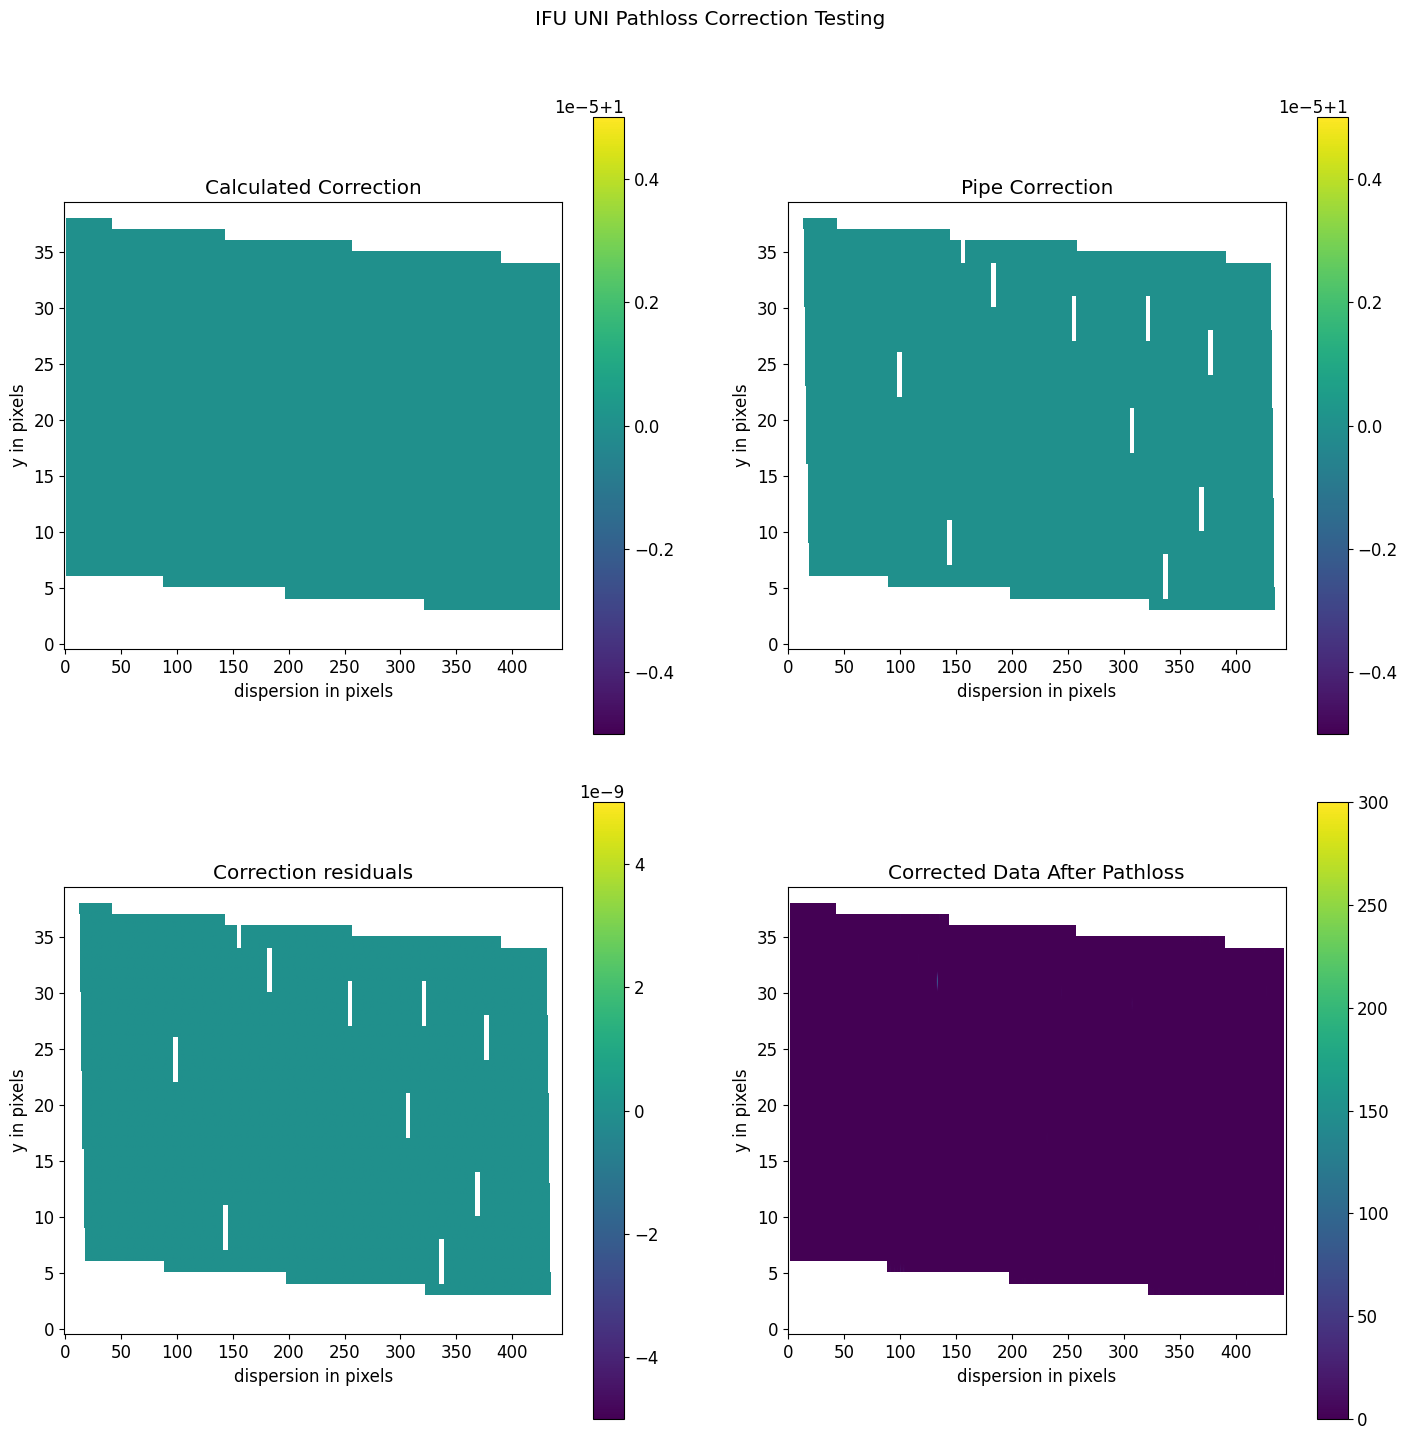

working with slice 18
SHAPES (40, 436) (39, 435)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V6
final left 336, right 375, top 1049, bottom 614
NEW SHAPE OF SLICE: (39, 435) and corr_vals.shape: (39, 435)


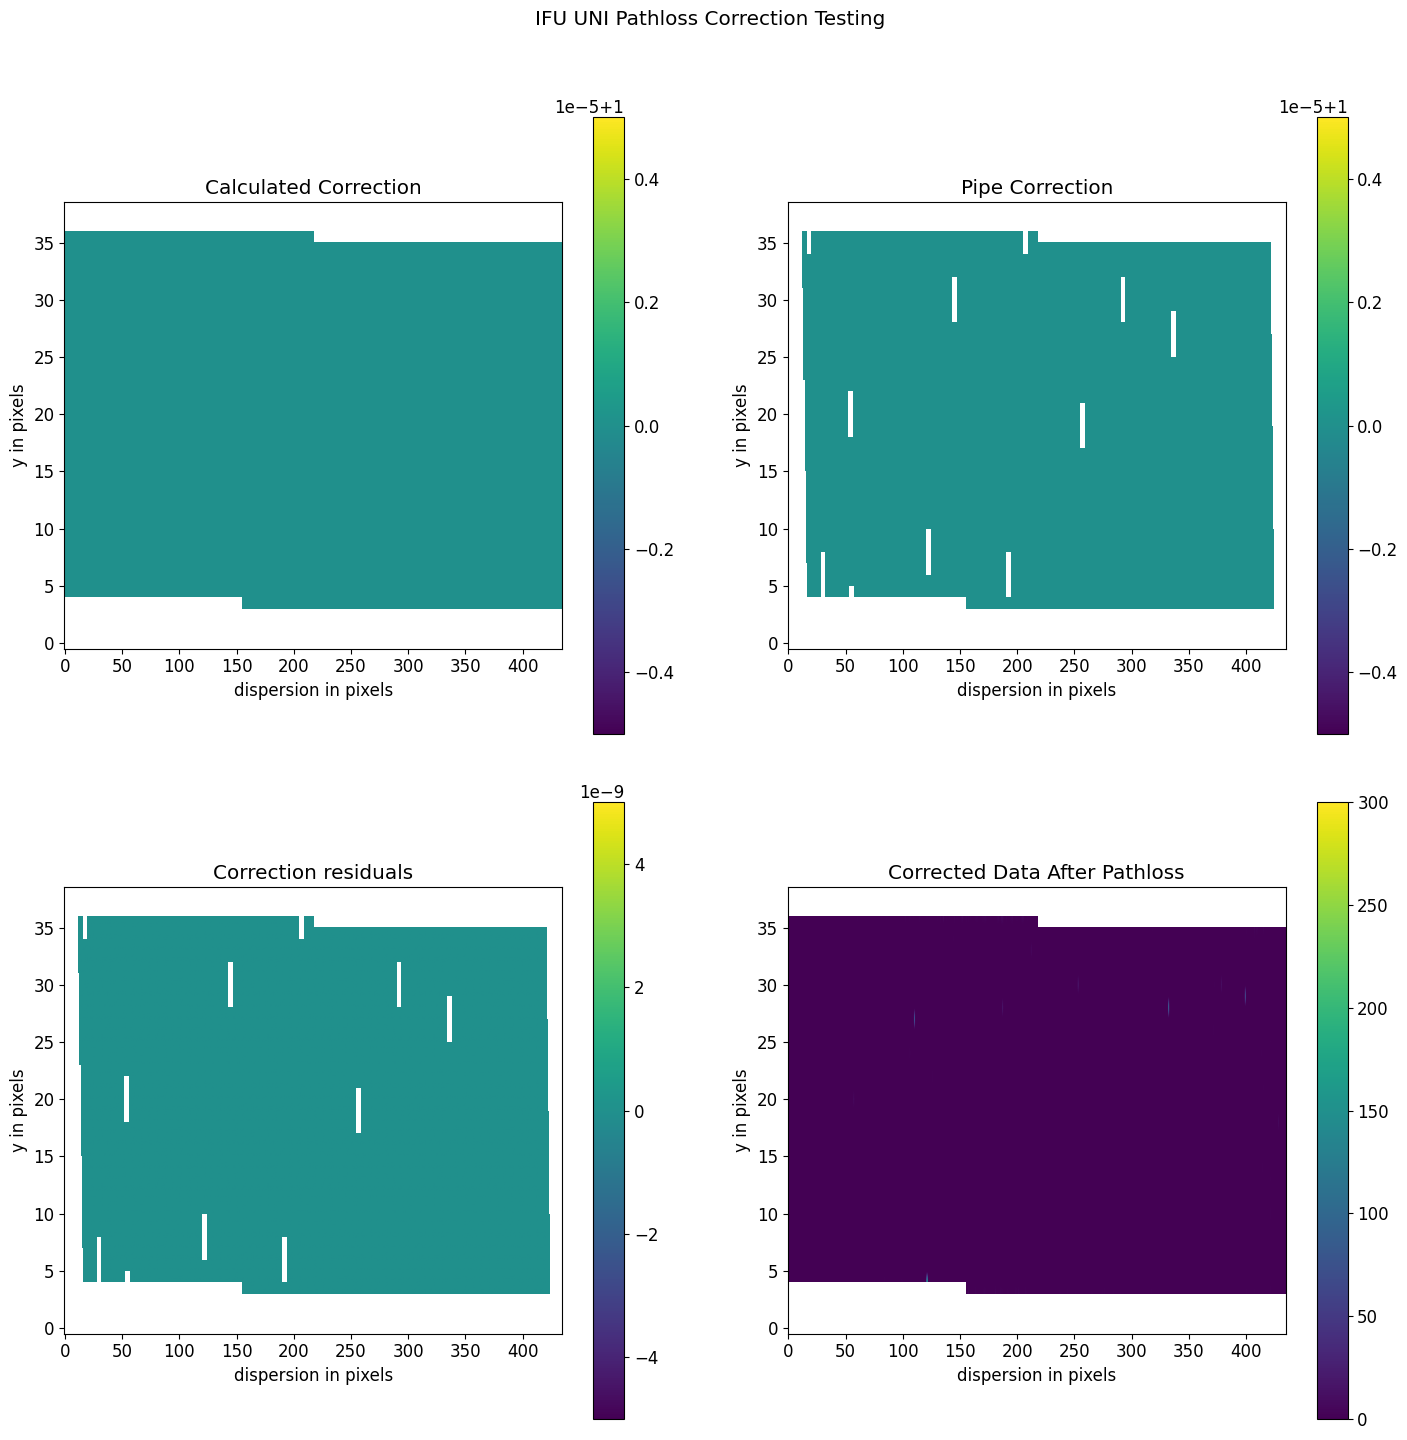

working with slice 19
SHAPES (41, 445) (40, 445)
ALTERED SHAPE OF SLICE: V2
final left 1639, right 1679, top 884, bottom 439
NEW SHAPE OF SLICE: (40, 445) and corr_vals.shape: (40, 445)


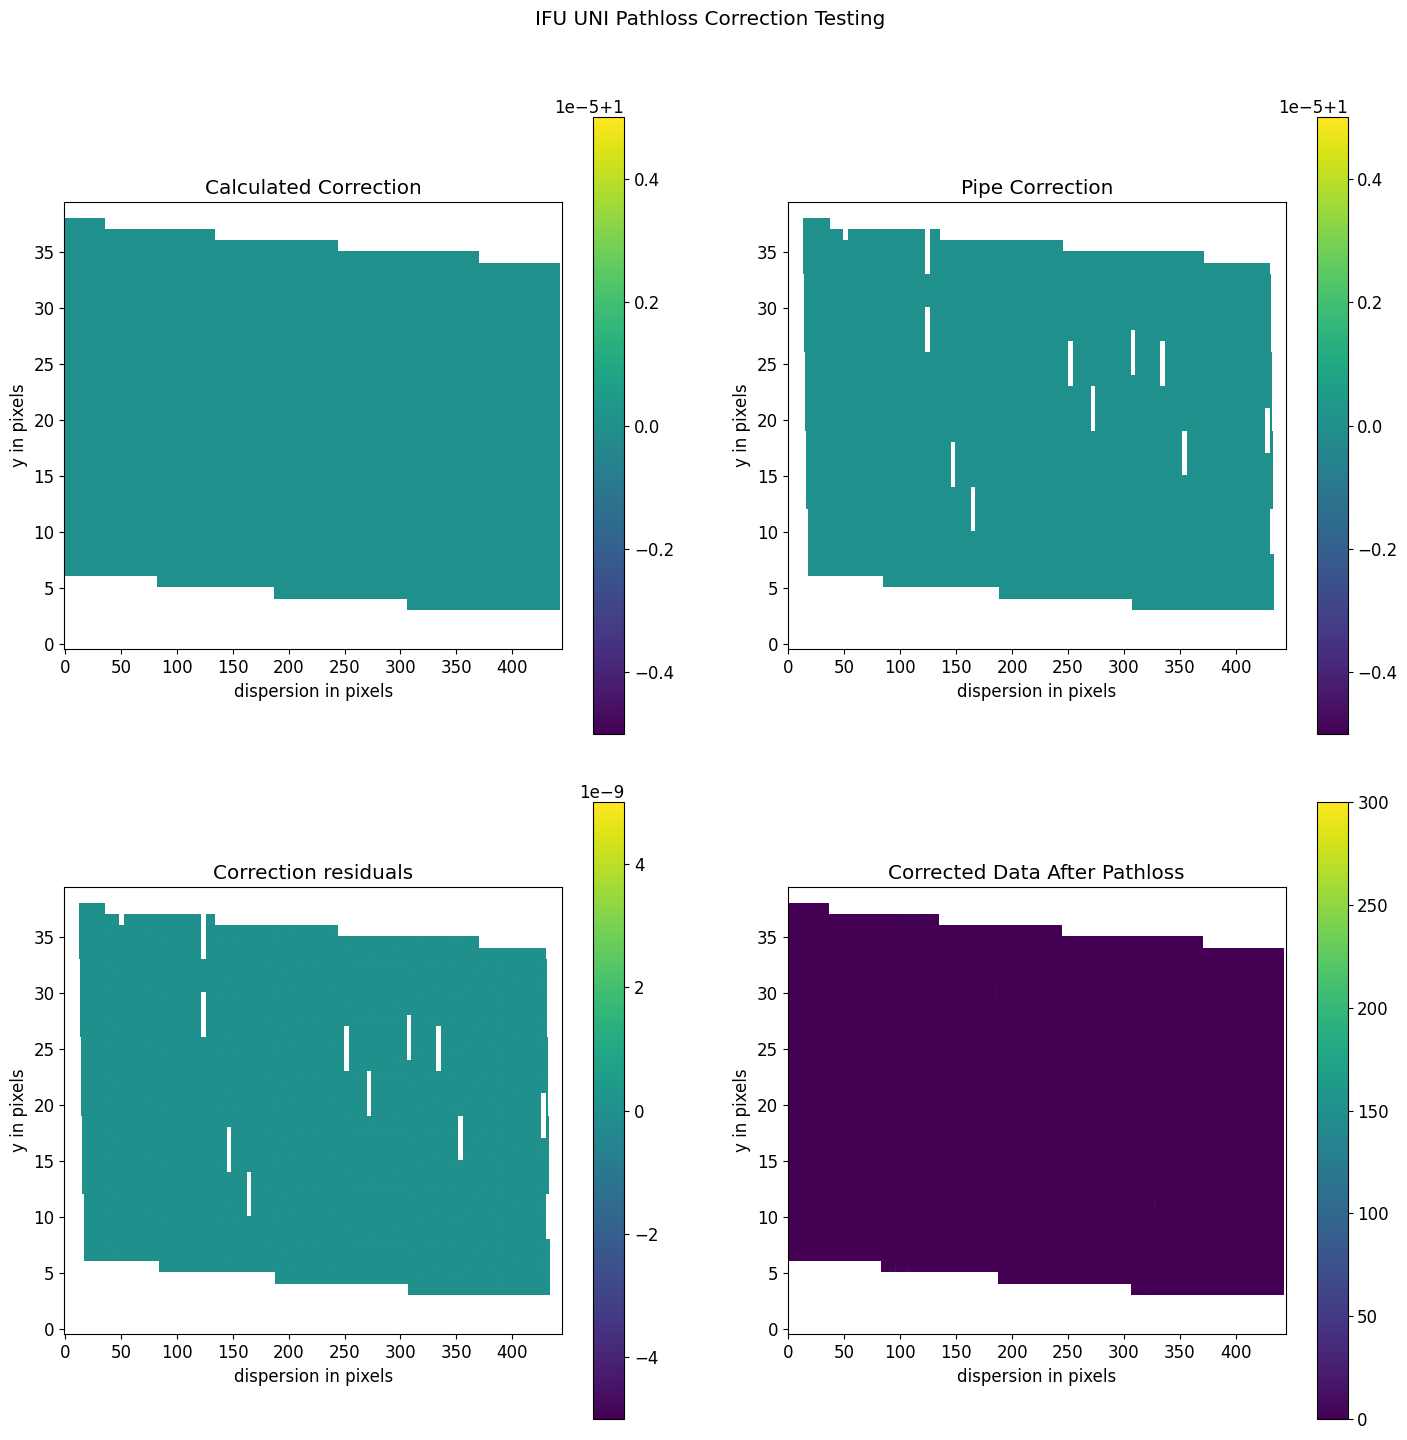

working with slice 20
SHAPES (40, 435) (39, 436)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 286, right 325, top 1054, bottom 618
NEW SHAPE OF SLICE: (39, 436) and corr_vals.shape: (39, 436)


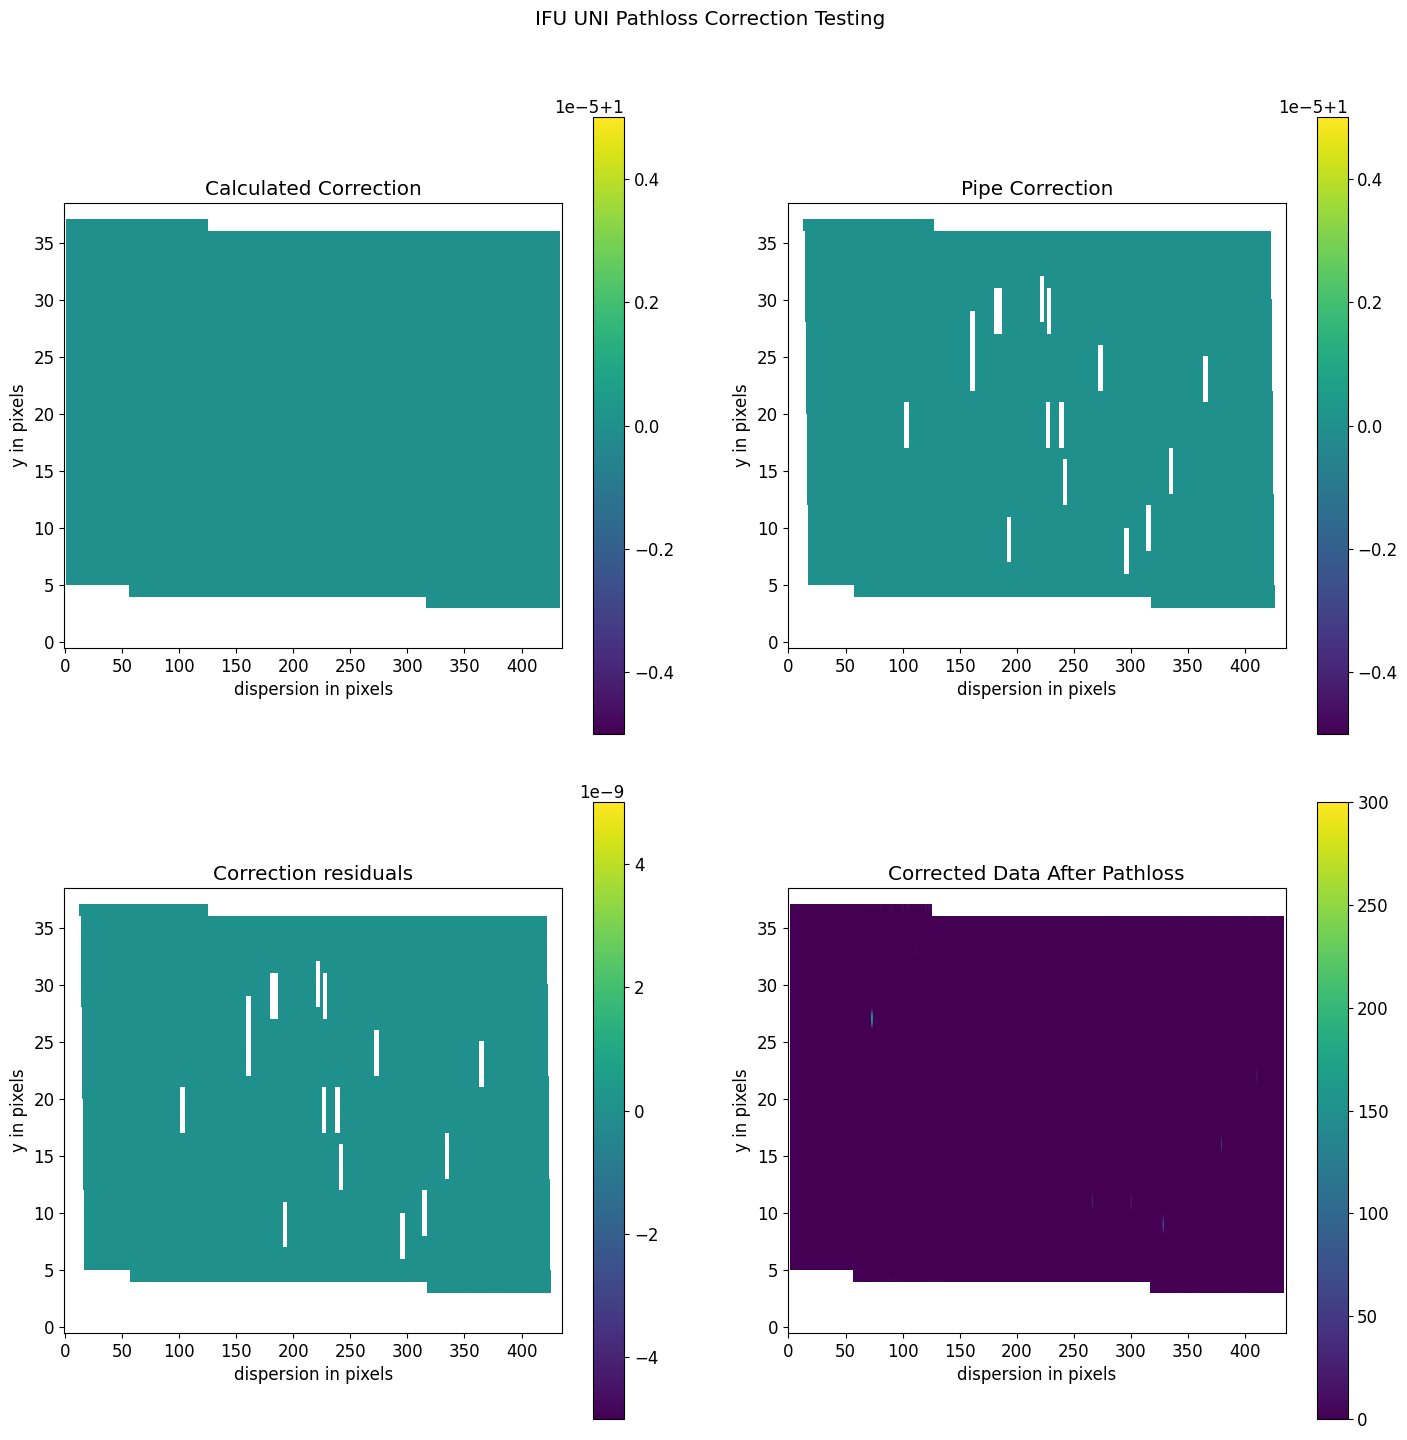

working with slice 21
SHAPES (41, 446) (40, 445)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V6
final left 1688, right 1728, top 877, bottom 432
NEW SHAPE OF SLICE: (40, 445) and corr_vals.shape: (40, 445)


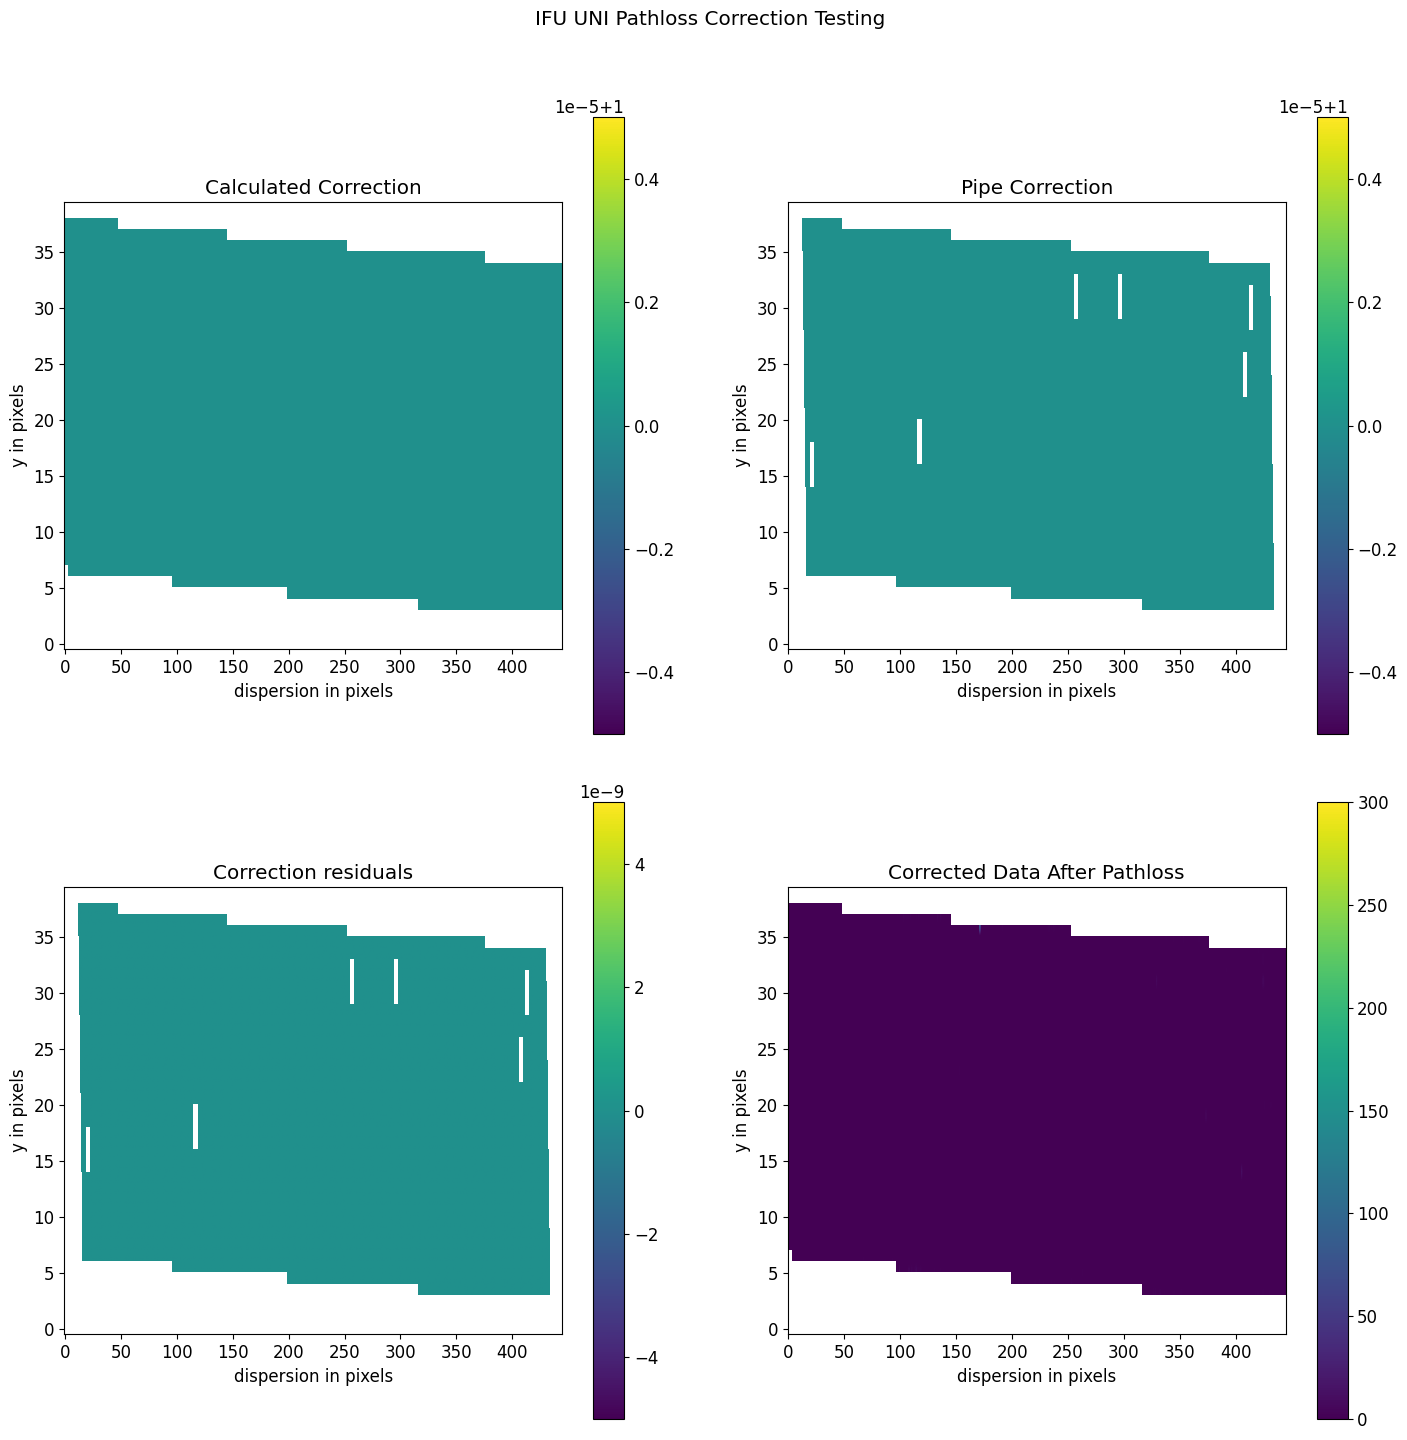

working with slice 22
SHAPES (40, 435) (39, 435)
ALTERED SHAPE OF SLICE: V2
final left 237, right 276, top 1059, bottom 624
NEW SHAPE OF SLICE: (39, 435) and corr_vals.shape: (39, 435)


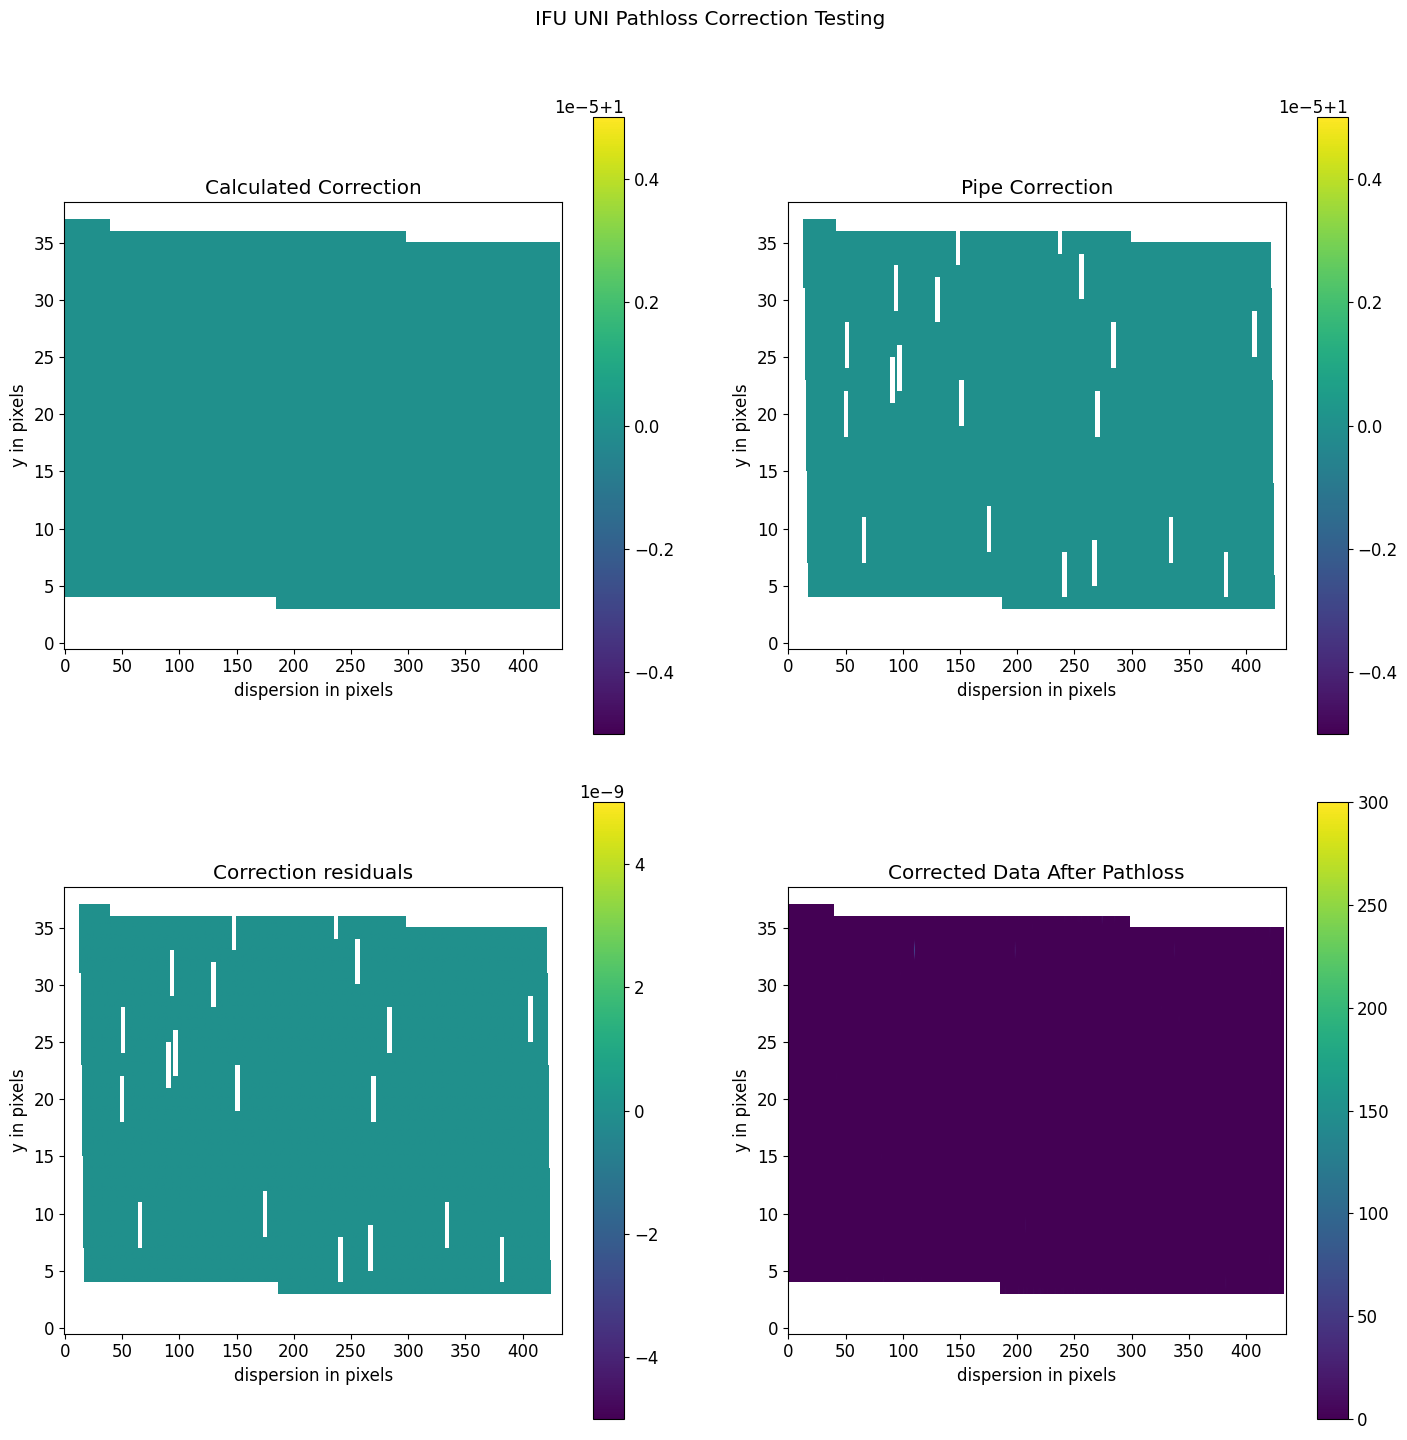

working with slice 23
SHAPES (41, 446) (40, 446)
ALTERED SHAPE OF SLICE: V2
final left 1737, right 1777, top 870, bottom 424
NEW SHAPE OF SLICE: (40, 446) and corr_vals.shape: (40, 446)


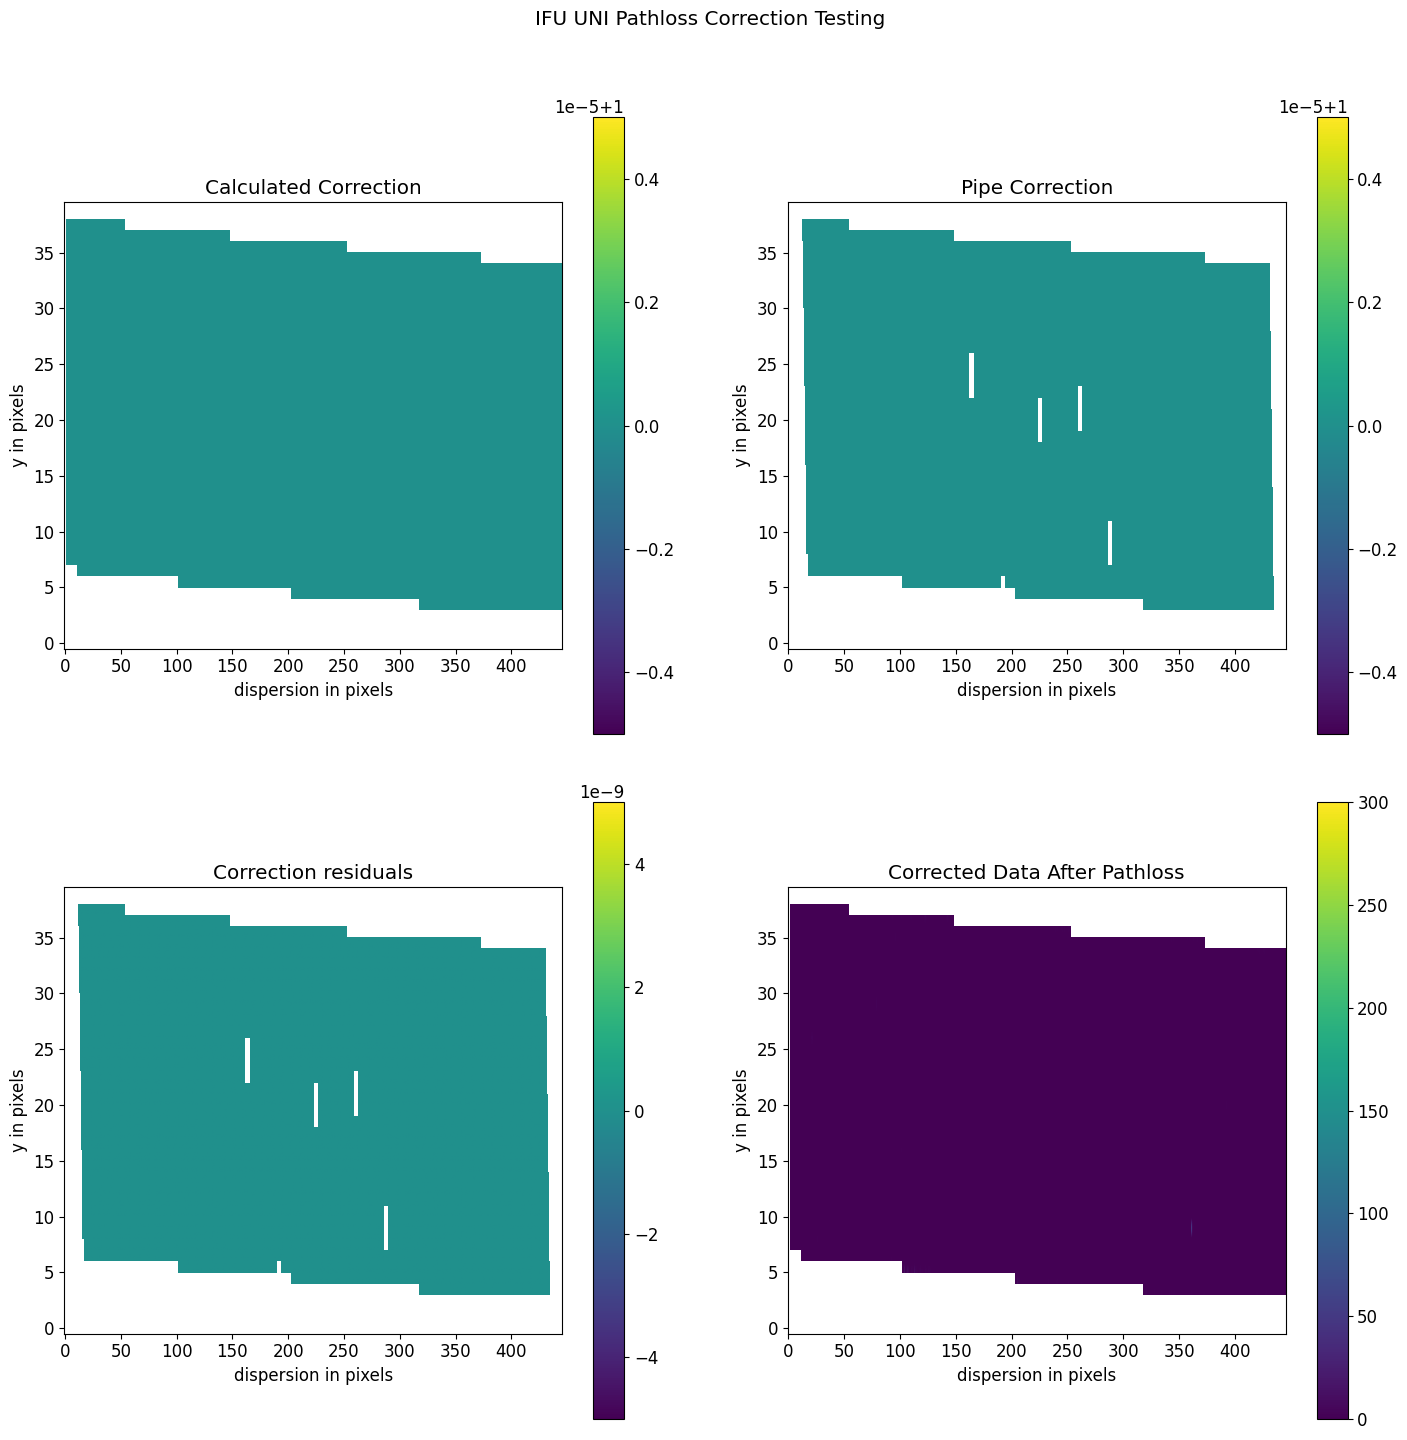

working with slice 24
SHAPES (40, 435) (39, 435)
ALTERED SHAPE OF SLICE: V2
final left 187, right 226, top 1064, bottom 629
NEW SHAPE OF SLICE: (39, 435) and corr_vals.shape: (39, 435)


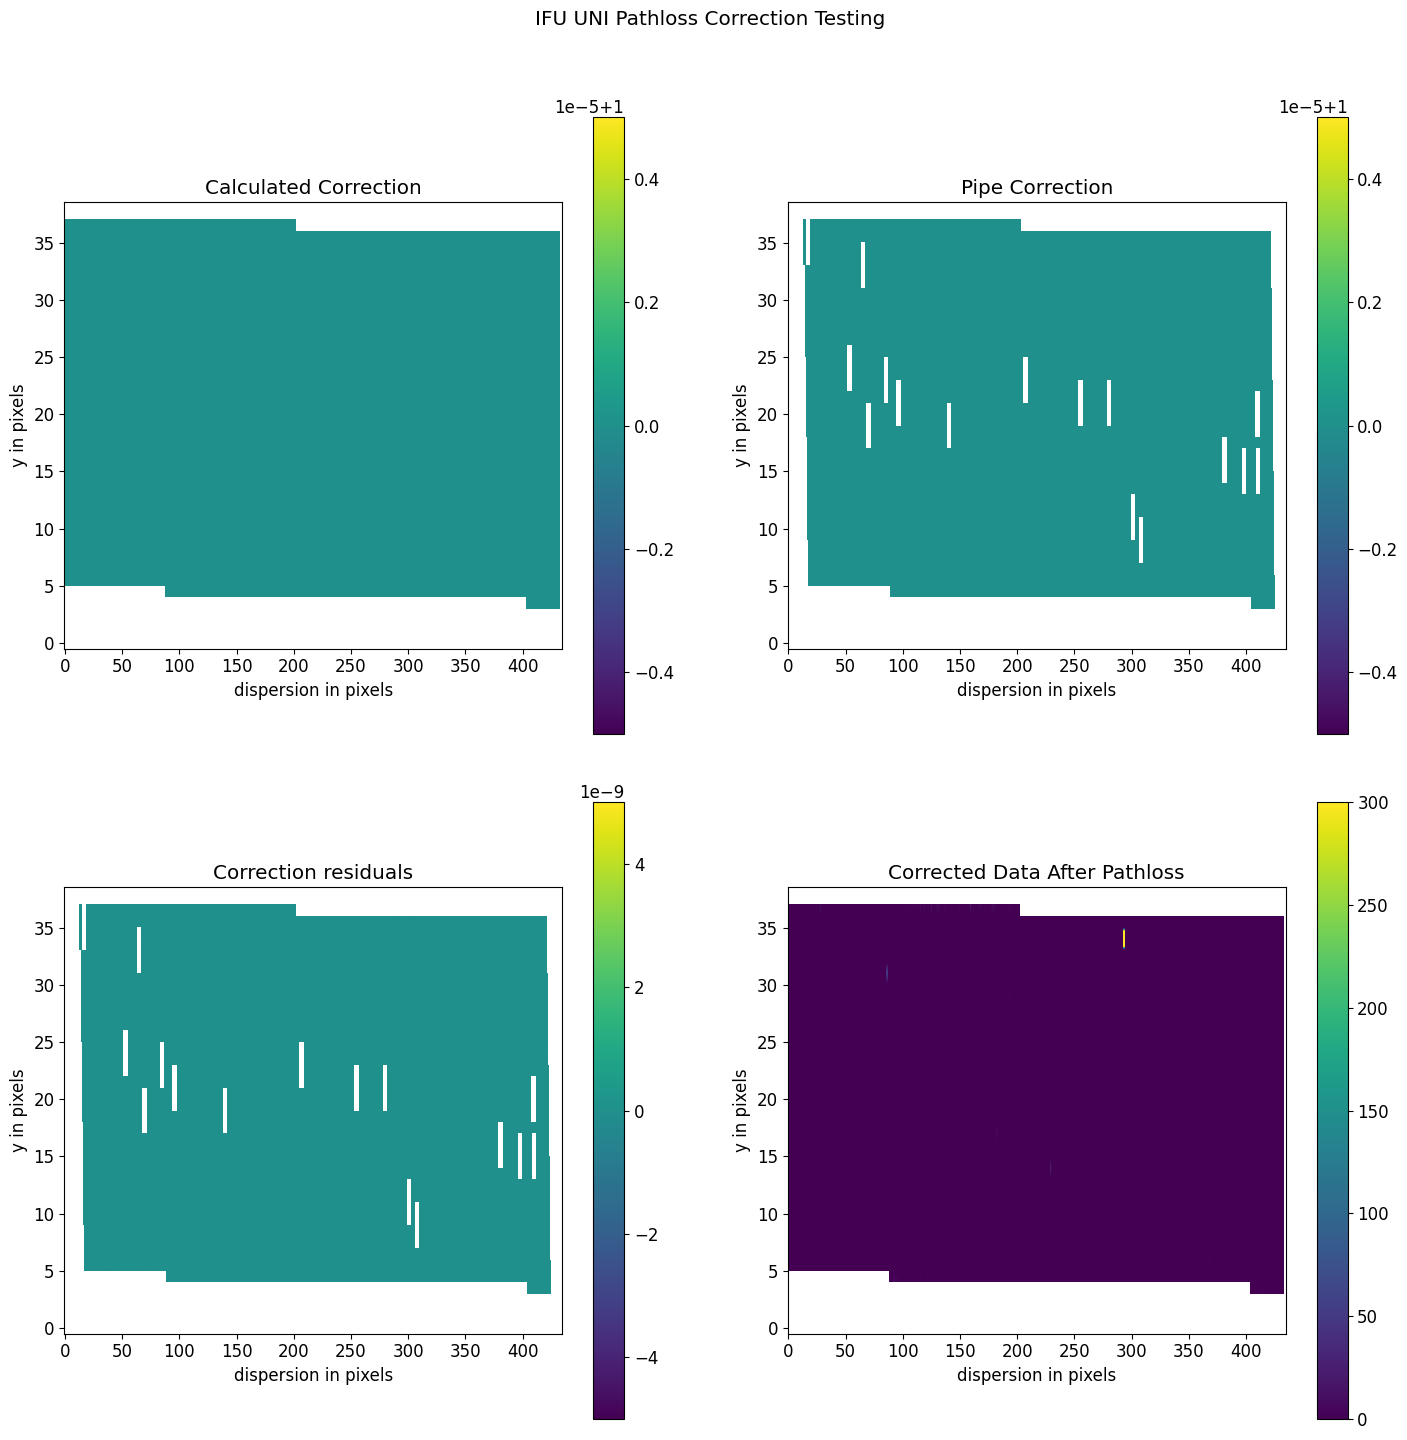

working with slice 25
SHAPES (42, 446) (41, 447)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 1785, right 1826, top 862, bottom 415
NEW SHAPE OF SLICE: (41, 447) and corr_vals.shape: (41, 447)


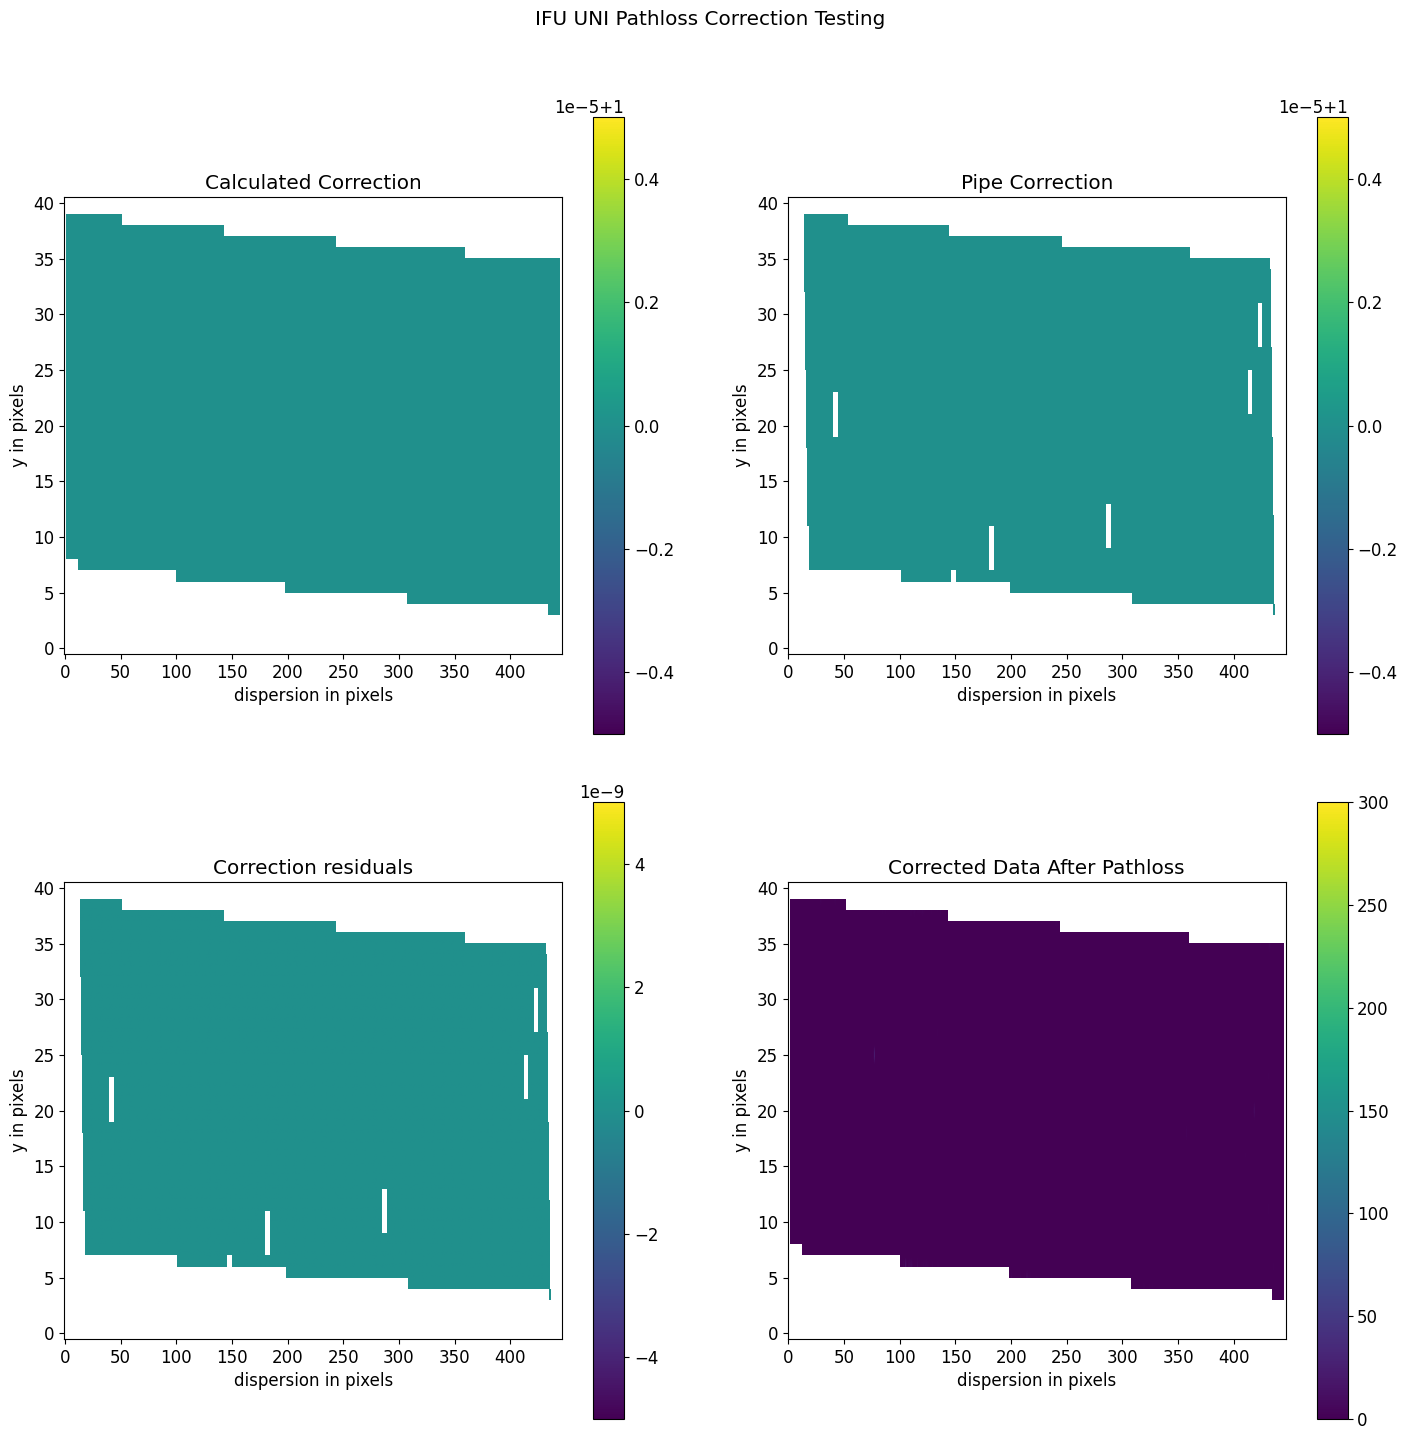

working with slice 26
SHAPES (40, 435) (39, 435)
ALTERED SHAPE OF SLICE: V2
final left 138, right 177, top 1069, bottom 634
NEW SHAPE OF SLICE: (39, 435) and corr_vals.shape: (39, 435)


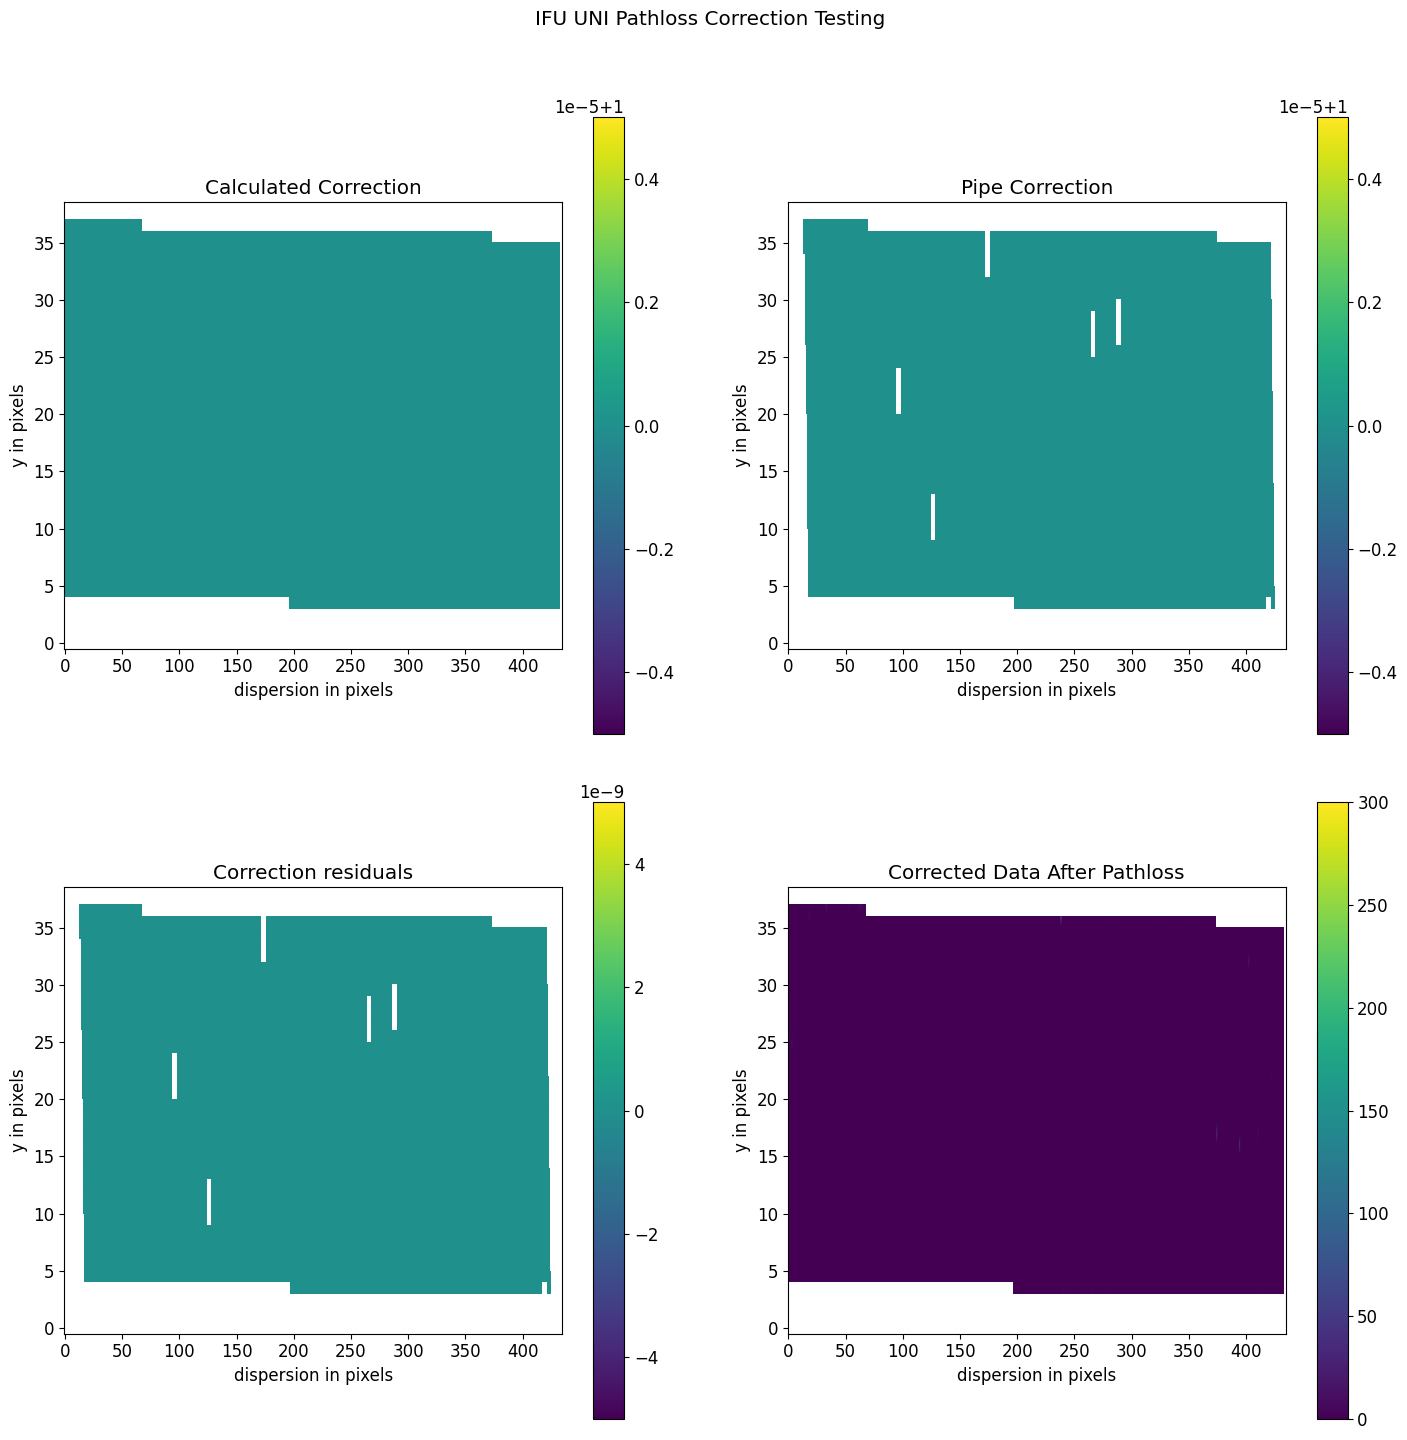

working with slice 27
SHAPES (42, 447) (41, 447)
ALTERED SHAPE OF SLICE: V2
final left 1834, right 1875, top 855, bottom 408
NEW SHAPE OF SLICE: (41, 447) and corr_vals.shape: (41, 447)


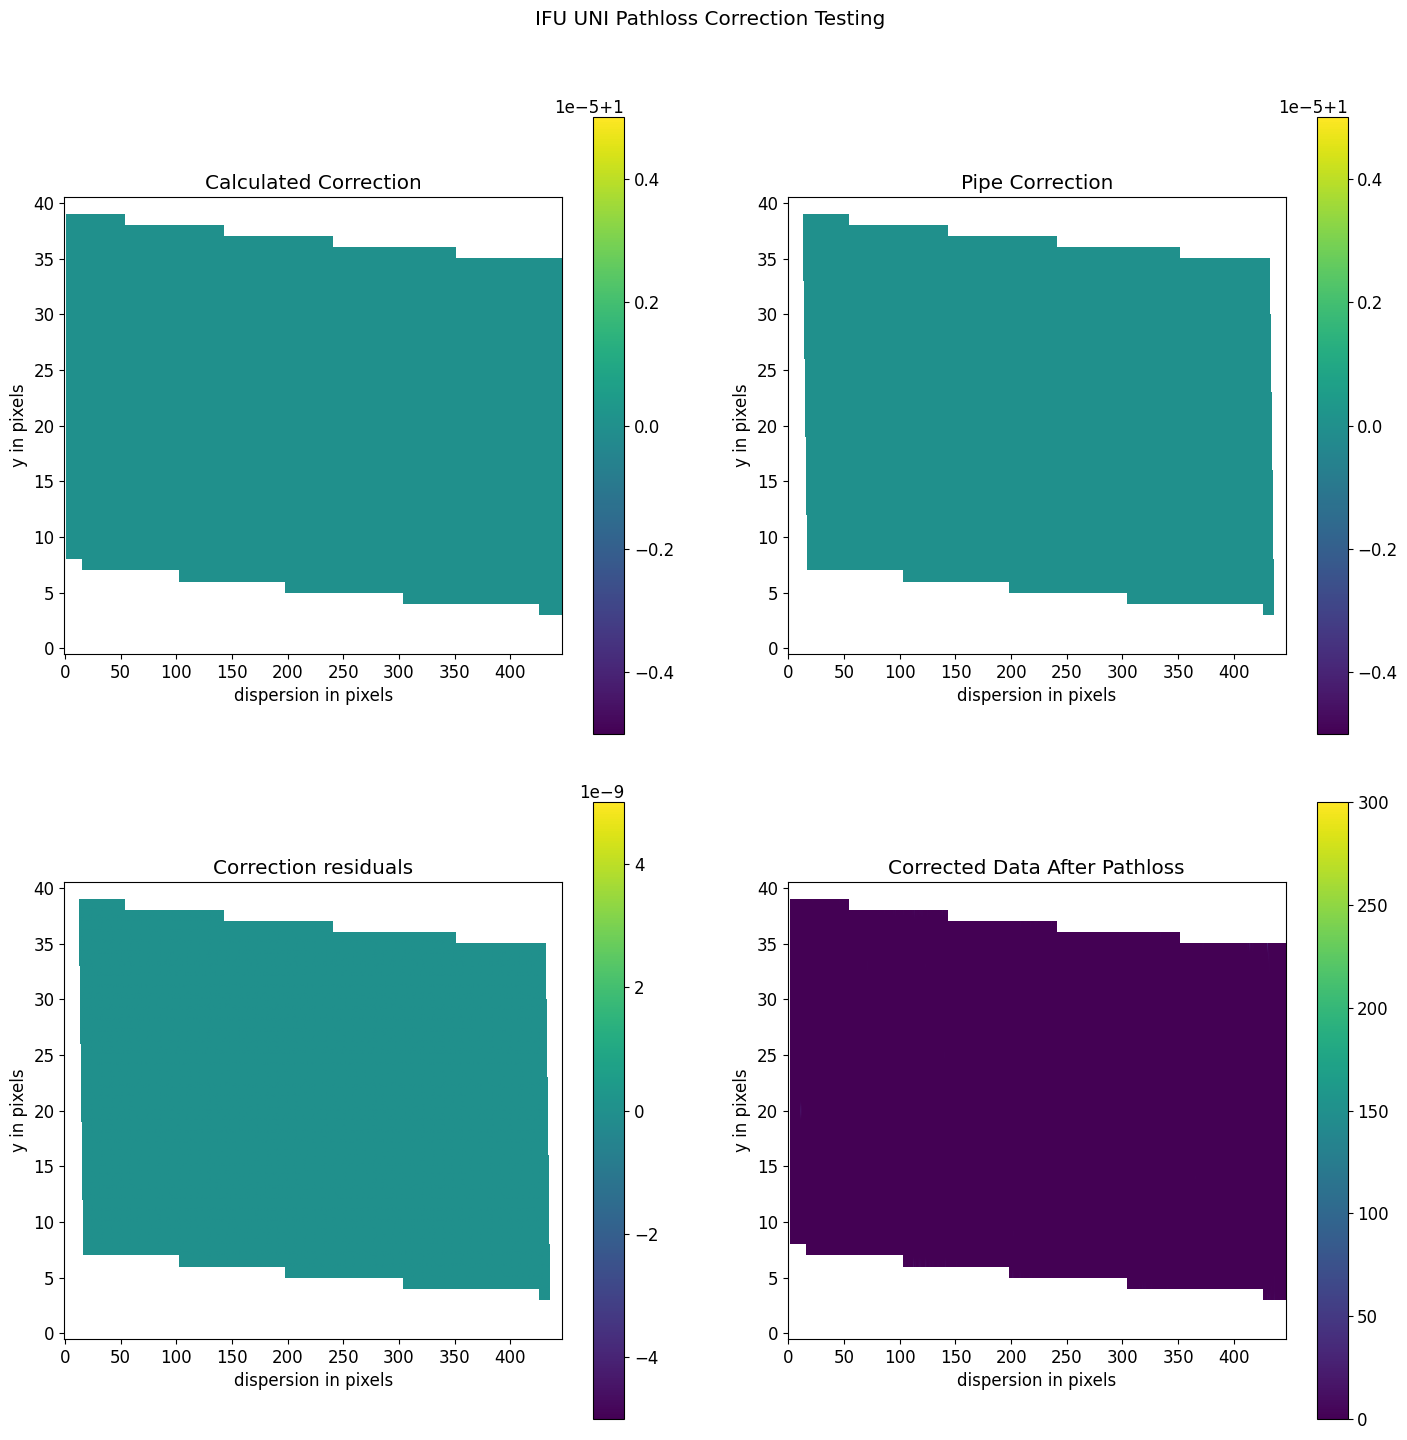

working with slice 28


SHAPES (40, 434) (39, 435)
ALTERED SHAPE OF SLICE: V2
ALTERED SHAPE OF SLICE: V8
final left 88, right 127, top 1074, bottom 639
NEW SHAPE OF SLICE: (39, 435) and corr_vals.shape: (39, 435)


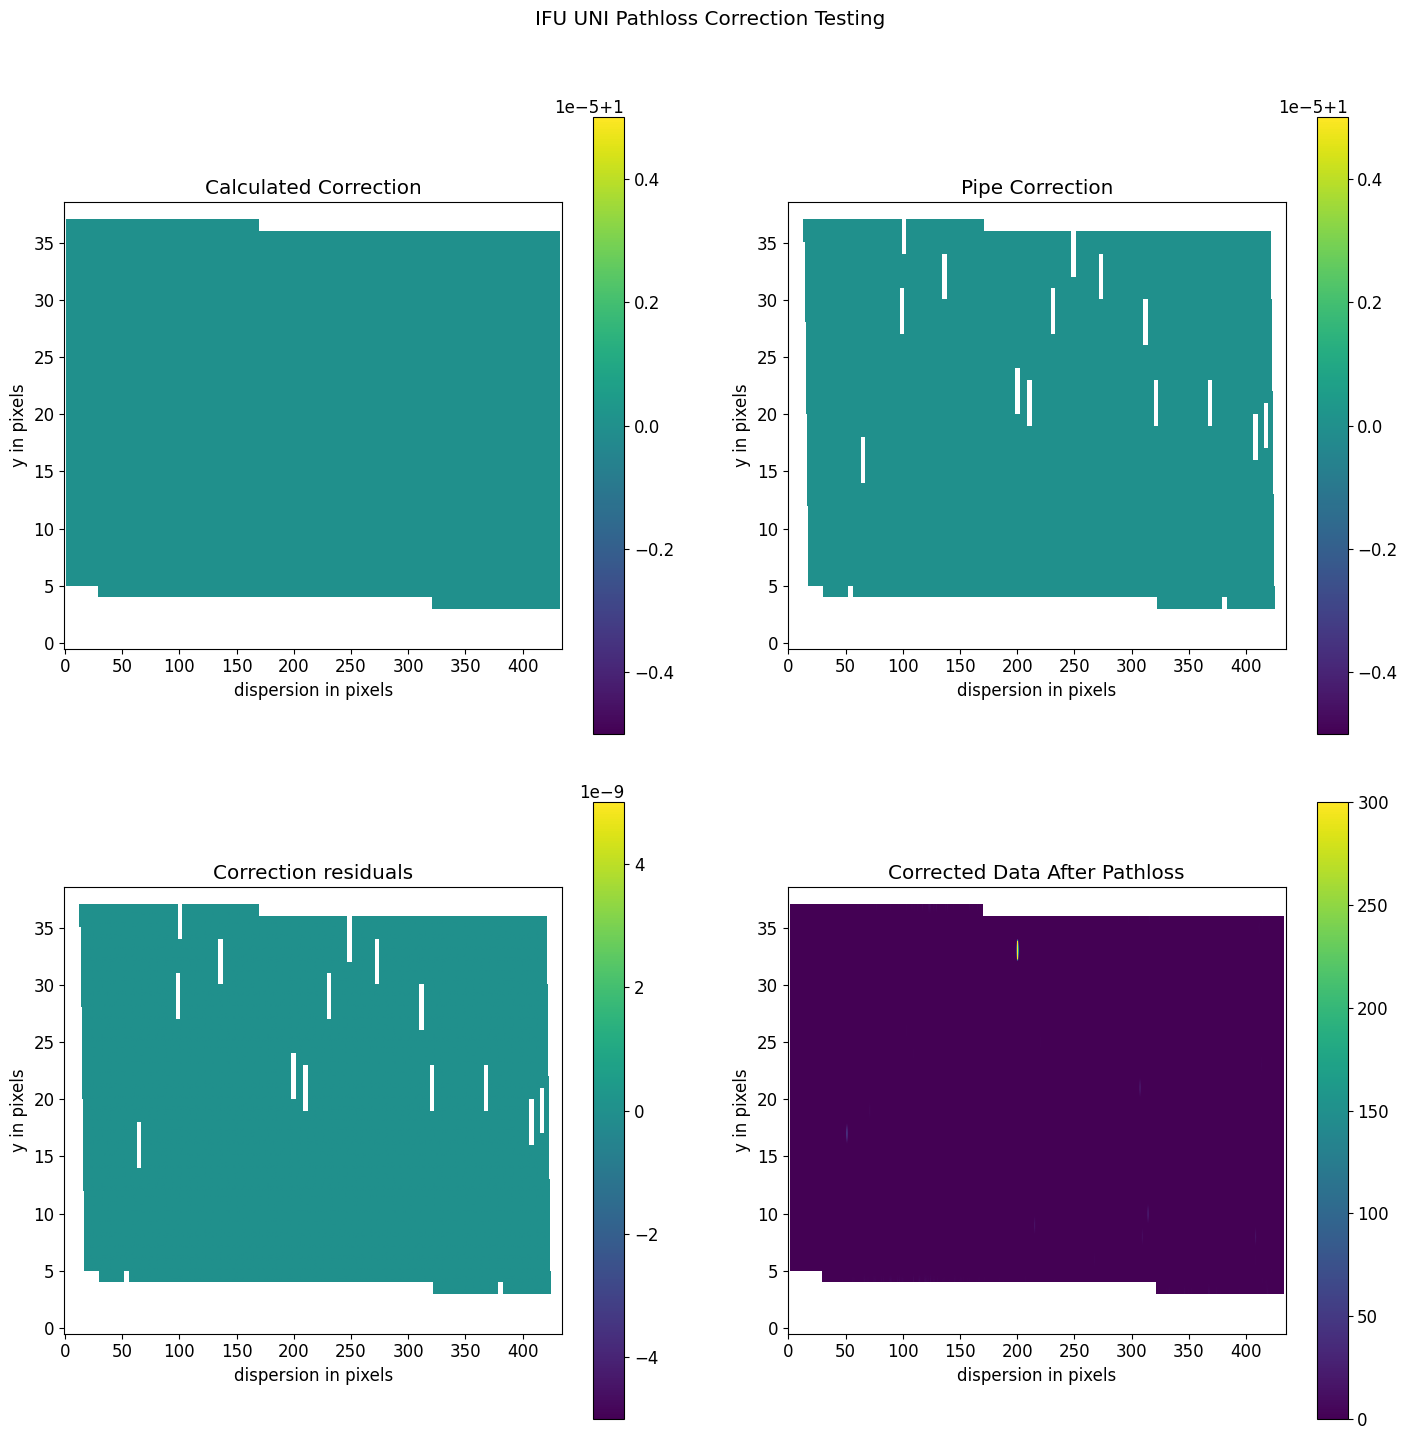

working with slice 29
SHAPES (42, 447) (41, 447)
ALTERED SHAPE OF SLICE: V2
final left 1883, right 1924, top 847, bottom 400
NEW SHAPE OF SLICE: (41, 447) and corr_vals.shape: (41, 447)


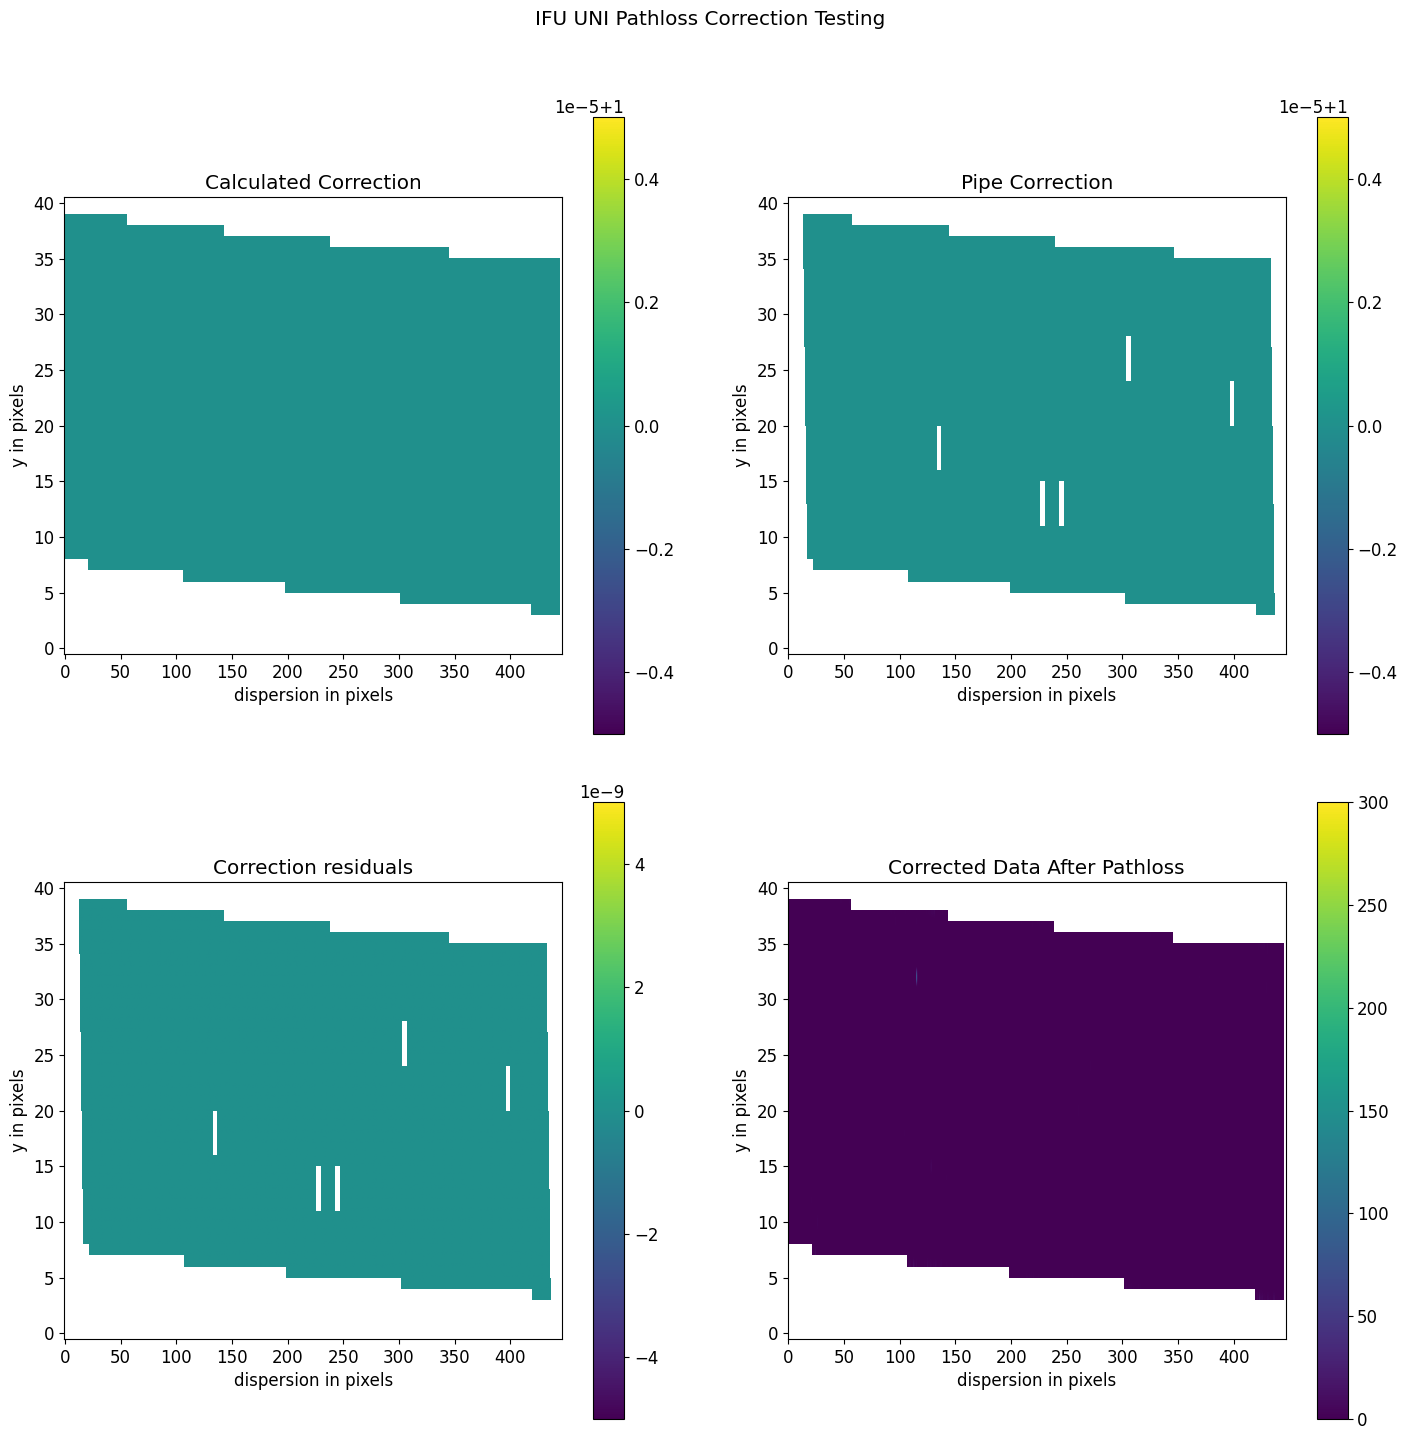

Calculating statistics... 

   Absolute Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   AbsoluteDifference = 0.000e+00
    Minimum   AbsoluteDifference = 0.000e+00
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final result of pathloss test is PASSED *** 

('* Script ifu_uni.py took ', '1.447238286336263 minutes to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 


Testing files for detector:  nrs2


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz/ifu_prism_nrs2_uncal.fits


2022-10-06 02:36:39,946 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-10-06 02:36:39,964 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 02:36:39,966 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 02:36:39,967 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 02:36:39,968 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 02:36:39,969 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 02:36:39,970 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 02:36:39,971 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 02:36:39,972 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 02:36:39,974 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 02:36:39,974 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 02:36:39,976 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 02:36:39,977 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 02:36:39,978 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 02:36:39,979 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 02:36:39,981 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 02:36:39,982 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 02:36:39,983 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 02:36:40,808 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz/ifu_prism_nrs2_uncal.fits',).


2022-10-06 02:36:40,818 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-10-06 02:36:41,028 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'ifu_prism_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 02:36:41,039 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0143.fits'.


2022-10-06 02:36:41,042 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits'.


2022-10-06 02:36:41,043 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0021.fits'.


2022-10-06 02:36:41,045 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits'.


2022-10-06 02:36:41,047 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 02:36:41,048 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits'.


2022-10-06 02:36:41,049 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-06 02:36:41,050 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-06 02:36:41,050 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-10-06 02:36:41,051 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0021.fits'.


2022-10-06 02:36:41,052 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0104.fits'.


2022-10-06 02:36:41,054 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 02:36:41,055 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 02:36:41,055 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 02:36:41,713 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:36:41,715 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:36:41,897 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-06 02:36:41,898 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 02:36:41,900 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 02:36:42,256 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:36:42,258 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:36:42,279 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits


2022-10-06 02:36:43,003 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 02:36:43,356 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:36:43,358 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz', 'n_pix_grow_sat': 1}


2022-10-06 02:36:43,380 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0021.fits


2022-10-06 02:36:45,420 - stpipe.Detector1Pipeline.saturation - INFO - Detected 21237 saturated pixels


2022-10-06 02:36:45,467 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 02:36:45,480 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 02:36:45,839 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:36:45,841 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:36:45,842 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-06 02:36:45,844 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 02:36:46,199 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:36:46,200 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:36:46,225 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0104.fits


2022-10-06 02:36:48,080 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-06 02:36:48,442 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:36:48,444 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 02:36:48,625 - stpipe.Detector1Pipeline.refpix - INFO - NIR full frame data


2022-10-06 02:36:48,626 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are valid for this mode:


2022-10-06 02:36:48,626 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-10-06 02:36:48,627 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-10-06 02:36:48,627 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-10-06 02:36:48,628 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-10-06 02:36:48,628 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is not applicable and is ignored:


2022-10-06 02:36:48,629 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-10-06 02:36:51,538 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 02:36:51,897 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:36:51,899 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:36:51,922 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0021.fits


2022-10-06 02:36:53,437 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 02:36:53,791 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:36:53,793 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz', 'dark_output': None}


2022-10-06 02:36:53,816 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0143.fits


2022-10-06 02:36:57,157 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-06 02:36:57,158 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-06 02:36:57,583 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 02:36:57,969 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:36:57,970 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 02:36:57,981 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-06 02:36:57,994 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-10-06 02:36:58,155 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits


2022-10-06 02:36:58,892 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 02:36:58,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-10-06 02:37:02,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13747 pixels with at least one CR from five or more groups.


2022-10-06 02:37:02,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 02:37:02,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 02:37:05,110 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.21707 sec


2022-10-06 02:37:05,115 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.134181


2022-10-06 02:37:05,121 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 02:37:05,513 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 10, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:37:05,515 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 02:37:05,550 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits


2022-10-06 02:37:05,551 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-10-06 02:37:05,661 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 02:37:05,662 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-06 02:37:47,630 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2022-10-06 02:37:47,631 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-10-06 02:37:47,853 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 02:37:48,263 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:37:48,265 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:37:48,344 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 02:37:48,345 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 02:37:48,349 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 02:37:48,699 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:37:48,700 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpuqo70bbz'}


2022-10-06 02:37:48,772 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 02:37:48,773 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 02:37:48,777 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 02:37:48,778 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 02:37:48,779 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 02:37:48,779 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 02:37:48,790 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 02:37:49,142 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<IFUImageModel(2048, 2048) from ifu_prism_nrs2_uncal.fits>,).


2022-10-06 02:37:49,144 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 02:37:49,306 - stpipe.AssignWcsStep - CRITICAL - No IFU slices fall on detector NRS2


An error occurred that made the pipeline crash, probably: No open slits fall on detector  nrs2
Skipping test for this file. 

Did pathloss validation test passed?  skipped 




In [7]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
threshold_diff = 9.999e-05

# other NPTT variables
writefile = False
show_figs = True
save_figs = False

# Get the data
detectors = ['nrs1', 'nrs2']
results_dict = {}
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        rate_object.meta.instrument.msa_metadata_file = msa_shutter_config
        if msa_shutter_config is not None:
            rate_object.meta.instrument.msa_metadata_file = msa_shutter_config
            print('MSA shutter configuration file: ', rate_object.meta.instrument.msa_metadata_file)

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
            skip_file = False
        except:
            print('An error occurred that made the pipeline crash, probably: No open slits fall on detector ', det)
            print("Skipping test for this file. \n")
            skip_file = True
            
        result_msg = 'skipped'
        if not skip_file:                        
            if 'ifu' in uncal_basename.lower() or 'mos' in uncal_basename.lower():
                pipe_object = MSAFlagOpenStep.call(pipe_object)
            if 'ifu' not in uncal_basename.lower():
                pipe_object = Extract2dStep.call(pipe_object)
            pipe_object = SourceTypeStep.call(pipe_object)
            pipe_object = WavecorrStep.call(pipe_object)
            flat_field_object = FlatFieldStep.call(pipe_object)
            pathloss_object = PathLossStep.call(flat_field_object)

            # get the corresponding reference file from the pathloss datamodel
            reffile_path = pathloss_object.meta.ref_file.pathloss.name.replace("crds://", 
                                                    "https://jwst-crds.stsci.edu/unchecked_get/references/jwst/")

            # Run the validation test
            %matplotlib inline

            if 'fs' in uncal_file.lower():
                print('Running test for FS...')
                
                source_type = pathloss_object.meta.target.source_type
                
                if source_type == 'POINT' or source_type is None:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile,
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)
                else:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_uni.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile, 
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)

            if 'mos' in uncal_file.lower():
                print('Running test for MOS...')
                median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_mos.pathtest(
                                                                                     flat_field_object, 
                                                                                     reffile_path,
                                                                                     pathloss_object,
                                                                                     writefile=writefile,
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)

            if 'ifu' in uncal_file.lower():
                print('Running test for IFU...')

                if pathloss_object.meta.target.source_type == 'POINT':
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_ps.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile,
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)
                else:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_uni.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile, 
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)

        # Did the test passed 
        print("Did pathloss validation test passed? ", result_msg, "\n\n")
        rd = {uncal_basename: result_msg}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                print('Closing file: ', fd)
                open(fd.fd).close()
            except:
                print('File already closed: ', fd)


In [8]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    if not isinstance(val, str):
        if val:
            val = 'PASSED'
        else:
            val = 'FAILED'
    print('{:<42} {:<8}'.format(key, val))


These are the final results of the tests: 
ifu_prism_nrs1_uncal.fits                  All slits PASSED path_loss test.
ifu_prism_nrs2_uncal.fits                  skipped 


<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Sr. Science Software Engineer, NIRSpec
<br>**Updated On:** Sep/26/2022

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 